In [1]:
import pandas as pd

# List of file paths to the TSV tables
file_paths = [
    "../data/rnaseq_gene_counts/salmon.merged.gene_counts (1).tsv",
    "../data/rnaseq_gene_counts/salmon.merged.gene_counts (2).tsv",
    "../data/rnaseq_gene_counts/salmon.merged.gene_counts (3).tsv",
    "../data/rnaseq_gene_counts/salmon.merged.gene_counts (4).tsv",
    "../data/rnaseq_gene_counts/salmon.merged.gene_counts.tsv"
]



In [3]:
# Initialize an empty DataFrame for merging
merged_df = None

# Loop through the files and merge them on 'gene_id' using an outer join
for file_path in file_paths:
    # Read the current file
    df = pd.read_csv(file_path, sep='\t')
    
    # Ignore the 'gene_name' column if it exists
    if 'gene_name' in df.columns:
        df = df.drop(columns=['gene_name'])
    
    # Merge with the existing DataFrame
    if merged_df is None:
        merged_df = df
    else:
        merged_df = pd.merge(merged_df, df, on='gene_id', how='outer')

# Write the merged DataFrame to a new TSV file
output_file = "../data/rnaseq_gene_counts/merged_gene_counts.tsv"
merged_df.to_csv(output_file, sep='\t', index=False)

print(f"Merged table saved to: {output_file}")


Merged table saved to: ../data/rnaseq_gene_counts/merged_gene_counts.tsv


In [4]:
!head -1 ../data/rnaseq_gene_counts/merged_gene_counts.tsv

gene_id	SRX7656957	SRX7656958	SRX7656959	SRX7656960	SRX7656961	SRX7656962	SRX7656963	SRX7656964	SRX7656965	SRX7656966	SRX7656967	SRX7656968	SRX7656969	SRX7656970	SRX7656971	SRX7656972	SRX7656973	SRX7656974	SRX7656975	SRX7656976	SRX7656977	SRX7656978	SRX7656979	SRX7656980	SRX7656981	SRX7656982	SRX7656983	SRX7656984	SRX7656985	SRX7656986	SRX7656987	SRX7656988	SRX7656989	SRX7656990	SRX7656991	SRX7656992	SRX7656993	SRX7656994	SRX7656995	SRX7656996	SRX13037862	SRX13037863	SRX13037864	SRX13037865	SRX13037866	SRX13037867	SRX13037868	SRX13037869	SRX13037870	SRX13037871	SRX9845500	SRX9845501	SRX9845502	SRX9845503	SRX9845504	SRX9845505	SRX9845506	SRX9845507	SRX9845508	SRX9845509	SRX9845510	SRX9845511	SRX9845512	SRX9845513	SRX9845514	SRX9845515	SRX9845516	SRX9845517	SRX9845518	SRX9845519	SRX9845520	SRX9845521	SRX9845522	SRX9845523	SRX9845524	SRX9845525	SRX9845526	SRX9845527	SRX9845528	SRX9845529	SRX9845530	SRX9845531	SRX9845532	SRX9845533	SRX9845534	SRX9845535	SRX9845536	SRX9845537	SRX9845538	SRX

In [5]:
!head -1 ../data/rnaseq_gene_counts/merged_gene_counts.tsv |\
tr '\t' '\n' |\
wc -l

218


there are 217 samples so including the 'gene_id' header there should be 218 strings

In [6]:
#see if any values are NaN
!grep 'NaN' ../data/rnaseq_gene_counts/merged_gene_counts.tsv |\
head

looks like there are values for all genes in the table. Now let's get the meta data

In [7]:
# List all metadata file paths (update the file paths or pattern accordingly)
metadata_files = [
    "../data/SraRunTable.csv",
    "../data/SraRunTable (1).csv",
    "../data/SraRunTable (2).csv",
    "../data/SraRunTable (3).csv",
    "../data/SraRunTable (4).csv"
]


In [47]:
from glob import glob

# Define the columns of interest
columns_of_interest = [
    "Experiment", "infection", "BREED", "treatment",
    "Trait", "tissue", "collection_time", "Collection_Date", "BioProject"
]

# Load and process each file, keeping only the columns of interest
processed_metadata = []
for file in metadata_files:
    # Read metadata file
    metadata = pd.read_csv(file)
    
    # Keep only the desired columns, fill missing columns with NaN
    filtered_metadata = metadata.reindex(columns=columns_of_interest)
    processed_metadata.append(filtered_metadata)

# Combine all metadata into a single DataFrame
merged_metadata = pd.concat(processed_metadata, ignore_index=True)

print(merged_metadata)


      Experiment infection                     BREED    treatment      Trait  \
0    SRX18040064       NaN   ABC_VIMS_Family_2017084  Dose 1x10^6   tolerant   
1    SRX18040063       NaN   ABC_VIMS_Family_2017084      Control   tolerant   
2    SRX18040062       NaN   ABC_VIMS_Family_2017120  Dose 1x10^6  sensitive   
3    SRX18040061       NaN   ABC_VIMS_Family_2017120  Dose 1x10^8  sensitive   
4    SRX18040060       NaN   ABC_VIMS_Family_2017090  Dose 1x10^6  sensitive   
..           ...       ...                       ...          ...        ...   
212   SRX7172535       NaN  ABC_VIMS_Family_2014_242          NaN  sensitive   
213   SRX7172532       NaN  ABC_VIMS_Family_2014_242          NaN  sensitive   
214   SRX7172531       NaN  ABC_VIMS_Family_2014_242          NaN  sensitive   
215   SRX7172527       NaN  ABC_VIMS_Family_2014_242          NaN  sensitive   
216   SRX7172526       NaN  ABC_VIMS_Family_2014_242          NaN  sensitive   

     tissue  collection_time Collection

In [49]:
#added column to denote subset (0 = exclude, 1 = include). 
#dataset 1: exclude treatment 'Dose 1x10^6'
#dataset 2: exclude infection 'B'
#dataset 3: include all
#dataset 4: exclude treatment 'Fed'
#dataset 5: exclude Collection_Date '6/26/2015


import pandas as pd

# Define criteria for each unique bioproject
criteria = {
    "PRJNA590205": lambda x: 0 if x == "6/26/2015" else 1,
    "PRJNA604121": lambda x: 0 if x == "B" else 1,
    "PRJNA691949": lambda x: 0 if x == "Fed" else 1,
    "PRJNA894694": lambda x: 0 if x == "Dose 1x10^6" else 1
}


# Loop through each row and apply criteria
for index, row in merged_metadata.iterrows():
    BioProject = row["BioProject"]
    
    if BioProject in ["PRJNA691949", "PRJNA894694"]:
        column_to_check = "treatment"
    if BioProject in ["PRJNA590205"]:
        column_to_check = "Collection_Date"
    if BioProject in ["PRJNA604121"]:
        column_to_check = "infection"
    
    if BioProject in criteria:
        merged_metadata.at[index, "subset"] = criteria[BioProject](row[column_to_check])
    else merged_metadata.at[index, "subset"] == 1
print(merged_metadata)

# Save the merged metadata to a new file
merged_metadata.to_csv("../data/merged_metadata.csv", index=False)
print("Merged metadata saved to 'merged_metadata.csv'")

SyntaxError: invalid syntax (2331113043.py, line 33)

In [25]:
!cat ../data/merged_metadata.csv

Experiment,infection,BREED,treatment,Trait,tissue,collection_time,Collection_Date,BioProject,subset
SRX18040064,,ABC_VIMS_Family_2017084,Dose 1x10^6,tolerant,mantle,,6/20/2018,PRJNA894694,0.0
SRX18040063,,ABC_VIMS_Family_2017084,Control,tolerant,mantle,,6/20/2018,PRJNA894694,1.0
SRX18040062,,ABC_VIMS_Family_2017120,Dose 1x10^6,sensitive,mantle,,6/20/2018,PRJNA894694,0.0
SRX18040061,,ABC_VIMS_Family_2017120,Dose 1x10^8,sensitive,mantle,,6/20/2018,PRJNA894694,1.0
SRX18040060,,ABC_VIMS_Family_2017090,Dose 1x10^6,sensitive,mantle,,6/20/2018,PRJNA894694,0.0
SRX18040059,,ABC_VIMS_Family_2017120,Dose 1x10^7,sensitive,mantle,,6/20/2018,PRJNA894694,1.0
SRX18040057,,ABC_VIMS_Family_2017090,Control,sensitive,mantle,,6/20/2018,PRJNA894694,1.0
SRX18040056,,ABC_VIMS_Family_2017089,Dose 1x10^6,tolerant,mantle,,6/20/2018,PRJNA894694,0.0
SRX18040055,,ABC_VIMS_Family_2017084,Dose 1x10^8,tolerant,mantle,,6/20/2018,PRJNA894694,1.0
SRX18040058,,ABC_VIMS_Family_2017090,Dose 1x10^8,sensitive,mantle,,6/20/201

In [23]:
!wc -l ../data/merged_metadata.csv

218 ../data/merged_metadata.csv


In [24]:
!head -1 ../data/rnaseq_gene_counts/merged_gene_counts.tsv | awk -F"\t" '{print NF}' 

218


In [26]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [27]:
# Replace with the correct paths to your files
gene_counts = pd.read_csv("../data/rnaseq_gene_counts/merged_gene_counts.tsv", sep='\t')
metadata = pd.read_csv("../data/merged_metadata.csv")

# Simplify metadata for alignment
metadata.rename(columns={'Experiment': 'Sample'}, inplace=True)

# Align gene counts with metadata
gene_count_samples = set(gene_counts.columns[1:])
metadata_samples = set(metadata['Sample'])
aligned_gene_counts = gene_counts[['gene_id'] + list(gene_count_samples.intersection(metadata_samples))]

# Filter genes with low expression (e.g., total counts < 10 across all samples)
filtered_gene_counts = aligned_gene_counts.loc[
    aligned_gene_counts.iloc[:, 1:].sum(axis=1) > 10
]

# Calculate CPM normalization
total_counts_per_sample = filtered_gene_counts.iloc[:, 1:].sum(axis=0)
cpm_counts = filtered_gene_counts.iloc[:, 1:].div(total_counts_per_sample, axis=1) * 1e6
cpm_counts.insert(0, 'gene_id', filtered_gene_counts['gene_id'])

# Transpose CPM data for visualization
cpm_values = cpm_counts.drop(columns='gene_id').T


In [28]:
len(metadata_samples)

217

In [29]:
len(gene_count_samples)

217

In [30]:
print(gene_count_samples)

{'SRX9845506', 'SRX9845512', 'SRX13037867', 'SRX7656989', 'SRX7172542', 'SRX7172574', 'SRX9845521', 'SRX7172528', 'SRX9845511', 'SRX9845534', 'SRX7172548', 'SRX7172569', 'SRX7172562', 'SRX7656971', 'SRX18040010', 'SRX13037866', 'SRX18040050', 'SRX7172546', 'SRX9845519', 'SRX9845514', 'SRX18040061', 'SRX18040044', 'SRX9845510', 'SRX18040048', 'SRX7656959', 'SRX18040043', 'SRX18040022', 'SRX7172568', 'SRX7656982', 'SRX7656958', 'SRX9845509', 'SRX18040041', 'SRX7656961', 'SRX7656963', 'SRX7656995', 'SRX18040025', 'SRX7656978', 'SRX9845527', 'SRX18040018', 'SRX18040033', 'SRX7172540', 'SRX18040014', 'SRX7656970', 'SRX7172529', 'SRX18040016', 'SRX7656967', 'SRX9845520', 'SRX18040034', 'SRX18040051', 'SRX18040046', 'SRX9845531', 'SRX7656990', 'SRX7172567', 'SRX9845540', 'SRX18040064', 'SRX18040032', 'SRX9845504', 'SRX9845516', 'SRX7656972', 'SRX9845522', 'SRX7172571', 'SRX9845501', 'SRX7172523', 'SRX7172570', 'SRX18040017', 'SRX9845526', 'SRX7172537', 'SRX7656962', 'SRX7172535', 'SRX7172573'

In [31]:
cpm_values.head()

,0,1,3,4,5,6,7,8,9,10,...,38259,38260,38261,38262,38263,38532,38533,38704,38740,38761
SRX9845512,0.466769,1.867075,0.0,14.599827,2.064518,11.142237,13.691261,0.000000,22.404900,0.700153,...,163.174889,0.466769,4.200919,28.006125,221.015006,0.0,0.0,0.0,0.0,0.000000
SRX7172542,7.338720,0.607929,0.0,23.136167,3.740589,12.595889,11.047088,0.607929,9.321582,0.810572,...,2.836395,2.431717,6.687222,22.088097,119.762069,0.0,0.0,0.0,0.0,0.000000
SRX13037867,0.322525,0.118794,0.0,4.444545,4.048962,5.144002,8.254614,0.000000,0.000000,1.425524,...,371.219194,2.138286,5.702095,96.698022,128.534718,0.0,0.0,0.0,0.0,0.356975
SRX7656989,0.587954,1.175908,0.0,3.490096,2.351816,22.591549,4.660712,0.000000,0.000000,1.175908,...,131.520632,1.763862,7.055449,42.920651,0.587954,0.0,0.0,0.0,0.0,0.000000
SRX9845506,0.500933,7.347023,0.0,45.815200,1.572430,7.818902,11.253969,0.000000,37.736981,0.500933,...,28.709995,7.847956,5.844223,27.551336,105.529965,0.0,0.0,0.0,0.0,0.000000


In [32]:
cpm_counts.head()

,gene_id,SRX9845512,SRX7172542,SRX13037867,SRX7656989,SRX9845506,SRX7172574,SRX9845521,SRX7172528,SRX9845511,...,SRX18040053,SRX7656966,SRX9845508,SRX9845502,SRX9845517,SRX9845543,SRX9845530,SRX7656993,SRX7172579,SRX18040006
0,LOC111099029,0.466769,7.338720,0.322525,0.587954,0.500933,11.748096,0.436742,1.083059,1.181792,...,7.522563,0.000000,0.000000,0.442103,0.994059,0.673711,0.000000,0.000000,14.548264,1.387286
1,LOC111099030,1.867075,0.607929,0.118794,1.175908,7.347023,0.856535,0.436742,4.014829,3.312331,...,0.056668,0.000000,0.371691,8.621004,22.845077,2.919413,1.298825,0.000000,22.409868,0.126117
3,LOC111099032,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,LOC111099033,14.599827,23.136167,4.444545,3.490096,45.815200,16.457613,16.588349,8.393591,6.386410,...,6.363297,1.261317,16.651552,24.602135,8.063319,71.659693,4.448044,6.020053,15.306125,3.131483
5,LOC111099034,2.064518,3.740589,4.048962,2.351816,1.572430,1.439979,1.791226,0.000000,1.498593,...,1.587396,0.000000,1.858453,2.374976,1.516516,1.796562,1.832065,1.505013,1.335702,4.931802


In [33]:
# Summary statistics for the raw (unnormalized) gene count data
raw_summary = filtered_gene_counts.describe()

# Calculate library sizes (total counts per sample)
library_sizes = filtered_gene_counts.sum(axis=0)

# Display key statistics
#raw_summary, library_sizes

In [34]:
# Convert index (rownames) to a column
cpm_values_ids = cpm_values.reset_index()

# Rename the new column if desired
cpm_values_ids.rename(columns={"index": "Sample"}, inplace=True)

#preview output
cpm_values_ids.head()

,Sample,0,1,3,4,5,6,7,8,9,...,38259,38260,38261,38262,38263,38532,38533,38704,38740,38761
0,SRX9845512,0.466769,1.867075,0.0,14.599827,2.064518,11.142237,13.691261,0.000000,22.404900,...,163.174889,0.466769,4.200919,28.006125,221.015006,0.0,0.0,0.0,0.0,0.000000
1,SRX7172542,7.338720,0.607929,0.0,23.136167,3.740589,12.595889,11.047088,0.607929,9.321582,...,2.836395,2.431717,6.687222,22.088097,119.762069,0.0,0.0,0.0,0.0,0.000000
2,SRX13037867,0.322525,0.118794,0.0,4.444545,4.048962,5.144002,8.254614,0.000000,0.000000,...,371.219194,2.138286,5.702095,96.698022,128.534718,0.0,0.0,0.0,0.0,0.356975
3,SRX7656989,0.587954,1.175908,0.0,3.490096,2.351816,22.591549,4.660712,0.000000,0.000000,...,131.520632,1.763862,7.055449,42.920651,0.587954,0.0,0.0,0.0,0.0,0.000000
4,SRX9845506,0.500933,7.347023,0.0,45.815200,1.572430,7.818902,11.253969,0.000000,37.736981,...,28.709995,7.847956,5.844223,27.551336,105.529965,0.0,0.0,0.0,0.0,0.000000


In [35]:
#merge meta data back with cpm data
metadata_cpm_values = pd.merge(metadata, cpm_values_ids, on='Sample', how='outer')
#preview output 
metadata_cpm_values.head()

,Sample,infection,BREED,treatment,Trait,tissue,collection_time,Collection_Date,BioProject,subset,...,38259,38260,38261,38262,38263,38532,38533,38704,38740,38761
0,SRX18040064,NaN,ABC_VIMS_Family_2017084,Dose 1x10^6,tolerant,mantle,NaN,6/20/2018,PRJNA894694,0.0,...,25.833391,20.425946,5.602053,15.254820,72.481942,0.0,0.0,0.0,0.0,0.0
1,SRX18040063,NaN,ABC_VIMS_Family_2017084,Control,tolerant,mantle,NaN,6/20/2018,PRJNA894694,1.0,...,215.640089,5.044787,7.269506,35.313506,237.042298,0.0,0.0,0.0,0.0,0.0
2,SRX18040062,NaN,ABC_VIMS_Family_2017120,Dose 1x10^6,sensitive,mantle,NaN,6/20/2018,PRJNA894694,0.0,...,292.493648,5.246568,8.846403,44.997939,222.040892,0.0,0.0,0.0,0.0,0.0
3,SRX18040061,NaN,ABC_VIMS_Family_2017120,Dose 1x10^8,sensitive,mantle,NaN,6/20/2018,PRJNA894694,1.0,...,68.322878,1.387313,6.603609,27.246822,117.533136,0.0,0.0,0.0,0.0,0.0
4,SRX18040060,NaN,ABC_VIMS_Family_2017090,Dose 1x10^6,sensitive,mantle,NaN,6/20/2018,PRJNA894694,0.0,...,1.315431,2.192386,4.384771,45.309301,69.864019,0.0,0.0,0.0,0.0,0.0


In [40]:
# Reshape the filtered CPM data to a long format for plotting
#.columns[10:]

cpm_long_format = metadata_cpm_values.melt(
    id_vars=["Sample","infection", "BREED", "treatment", "Trait", "tissue", "collection_time", "Collection_Date", "BioProject", "subset" ],  # Columns to keep
    var_name="Gene",                      # Name for gene column
    value_name="Count"                    # Name for count column
)

#preview output
cpm_long_format.head()


,Sample,infection,BREED,treatment,Trait,tissue,collection_time,Collection_Date,BioProject,subset,Gene,Count
0,SRX18040064,NaN,ABC_VIMS_Family_2017084,Dose 1x10^6,tolerant,mantle,NaN,6/20/2018,PRJNA894694,0.0,0,0.258556
1,SRX18040063,NaN,ABC_VIMS_Family_2017084,Control,tolerant,mantle,NaN,6/20/2018,PRJNA894694,1.0,0,1.193891
2,SRX18040062,NaN,ABC_VIMS_Family_2017120,Dose 1x10^6,sensitive,mantle,NaN,6/20/2018,PRJNA894694,0.0,0,0.651034
3,SRX18040061,NaN,ABC_VIMS_Family_2017120,Dose 1x10^8,sensitive,mantle,NaN,6/20/2018,PRJNA894694,1.0,0,2.083966
4,SRX18040060,NaN,ABC_VIMS_Family_2017090,Dose 1x10^6,sensitive,mantle,NaN,6/20/2018,PRJNA894694,0.0,0,0.146159


In [41]:
# Log-scale the CPM values (handling zeros by replacing them with NaN, if necessary)
cpm_long_format['log_CPM'] = np.log10(cpm_long_format['Count'].replace(0, np.nan))
cpm_long_format.head()

,Sample,infection,BREED,treatment,Trait,tissue,collection_time,Collection_Date,BioProject,subset,Gene,Count,log_CPM
0,SRX18040064,NaN,ABC_VIMS_Family_2017084,Dose 1x10^6,tolerant,mantle,NaN,6/20/2018,PRJNA894694,0.0,0,0.258556,-0.587445
1,SRX18040063,NaN,ABC_VIMS_Family_2017084,Control,tolerant,mantle,NaN,6/20/2018,PRJNA894694,1.0,0,1.193891,0.076965
2,SRX18040062,NaN,ABC_VIMS_Family_2017120,Dose 1x10^6,sensitive,mantle,NaN,6/20/2018,PRJNA894694,0.0,0,0.651034,-0.186396
3,SRX18040061,NaN,ABC_VIMS_Family_2017120,Dose 1x10^8,sensitive,mantle,NaN,6/20/2018,PRJNA894694,1.0,0,2.083966,0.318891
4,SRX18040060,NaN,ABC_VIMS_Family_2017090,Dose 1x10^6,sensitive,mantle,NaN,6/20/2018,PRJNA894694,0.0,0,0.146159,-0.835174


In [38]:
#import library for plotting facet plots
from plotnine import *
%matplotlib inline

# Create boxplots for each sample
plt = (
    ggplot(cpm_long_format, aes(x="Sample", y="log_CPM", fill = "Trait")) +
    geom_boxplot() +
    facet_wrap("~BioProject", scales="free_x") +
    labs(title="Gene Counts Boxplots by Sample", y="Log10(CPM)", x="Sample") +
    theme_bw() +    
    theme(axis_text_x=element_text(rotation=90, hjust=1)) +
    theme(figure_size=(12, 8)  # Adjust width and height in inches
    )
)

display(plt)

plt.save("../analyses/2025-01-03_RNAseq_all_AI_diffexp/Sample_logCPM_Boxplots.jpg", dpi = 300, units = "in", height = 8, width = 12)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f8d0cb21310>>
Traceback (most recent call last):
  File "/home/shellytrigg/bin/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

All samples show fairly even coverage and no super obvious outliers from here. 
The BioProject numbers are not in the same order as the datasets.
From the top left going clockwise the order is Dataset 2, Dataset 4, Dataset 1, and Dataset 3. 

Now I want to try a PCA 

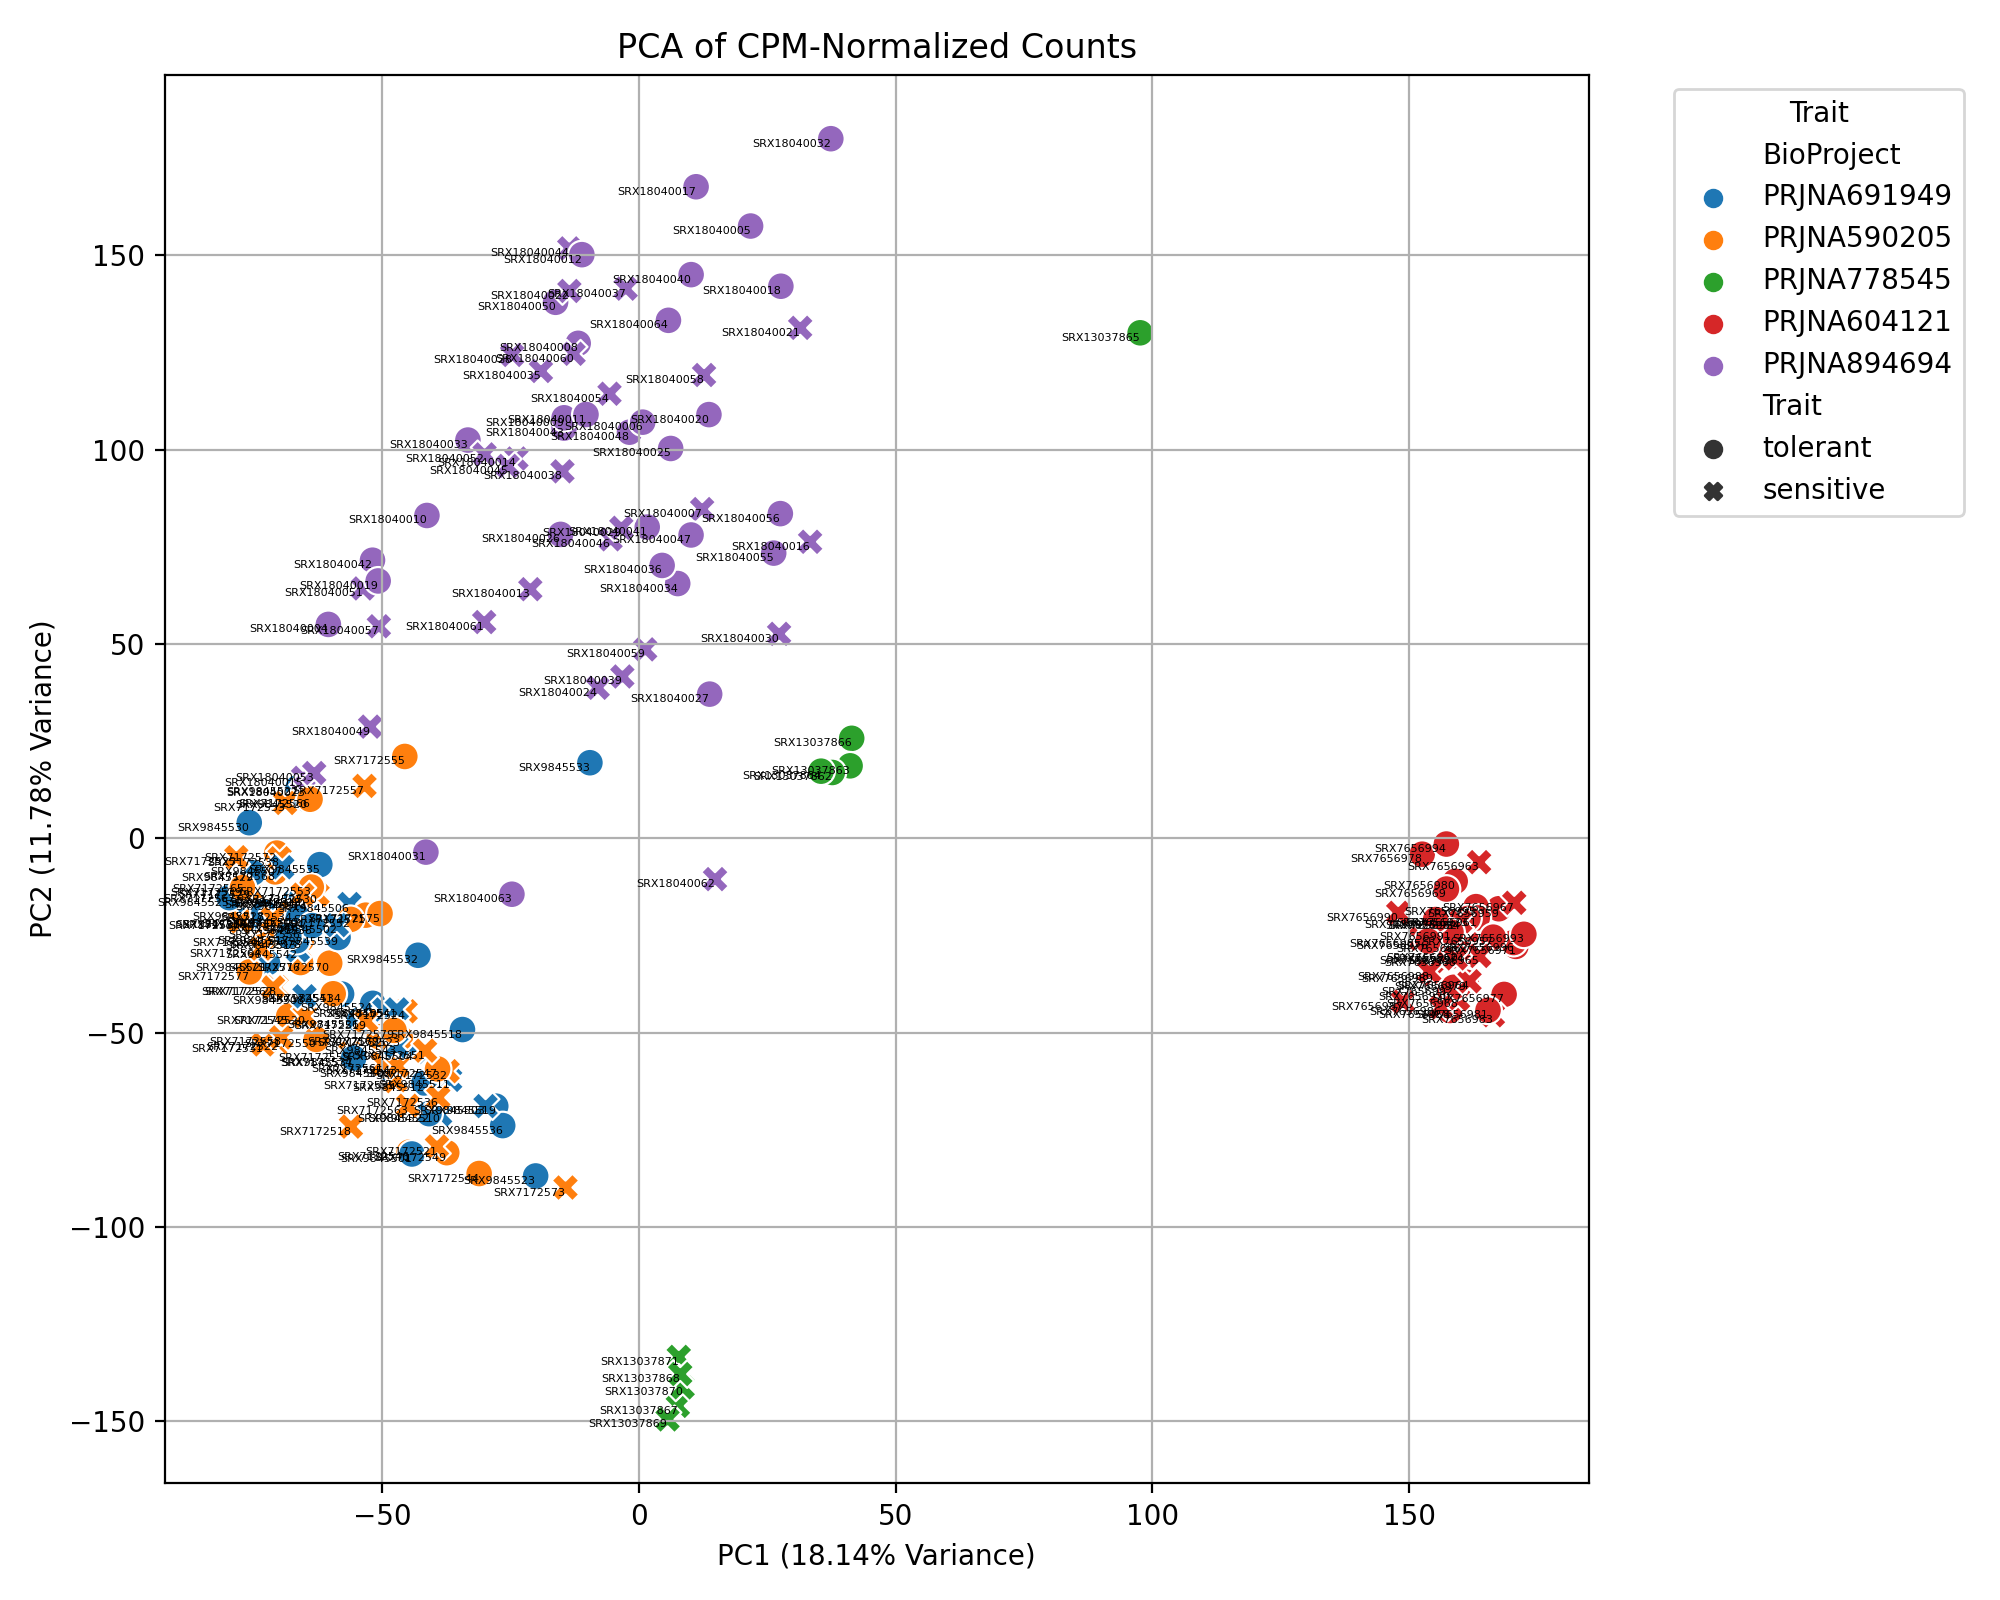

FileNotFoundError: [Errno 2] No such file or directory: '../analyses/2025-02-04_RNAseq_all_AI_diffexp/PCA_all_genes_normCPM.png'

<Figure size 640x480 with 0 Axes>

In [43]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Transpose the CPM data for PCA (genes as features, samples as rows)
pca_data = cpm_values

# Standardize the data (mean=0, variance=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(np.log10(pca_data + 1))  # Log-transform CPM values

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 principal components
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Sample'] = pca_data.index

# Merge with metadata to color by treatment or batch
pca_df = pd.merge(pca_df, metadata, left_on='Sample', right_on='Sample')

# Plot PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=pca_df, 
    x='PC1', y='PC2', 
    hue='BioProject',  # Color by treatment
    style='Trait',    # Style points by batch
    s=100
)

# Add sample ID annotations
for i, row in pca_df.iterrows():
    plt.text(
        x=row['PC1'], 
        y=row['PC2'], 
        s=row['Sample'], 
        fontsize=4, 
        ha='right', 
        va='top'
    )
    
plt.title('PCA of CPM-Normalized Counts')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)')
plt.legend(title='Trait', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()


plt.savefig("../analyses/2025-02-04_RNAseq_all_AI_diffexp/PCA_all_genes_normCPM.png")

samples seem to cluster by tissue and study with the green and orange samples being mantle tissue and the red and blue samples being gill tissue. Blue is clustered pretty far from the others and this could be because these samples were in the wild and not in controled environments like the others.

I still want to try the mutual information approach to see if any tolerant-associated genes are identified across studies

In [45]:
# Subset the DataFrame: Keep only rows where 'subset' column is 1
filtered_df = merged_metadata[merged_metadata['subset'] == 1]

# Transpose the CPM data for PCA (genes as features, samples as rows)
pca_data = cpm_values[cpm_values.index.isin(filtered_df['Experiment'])]

len(pca_data)

151

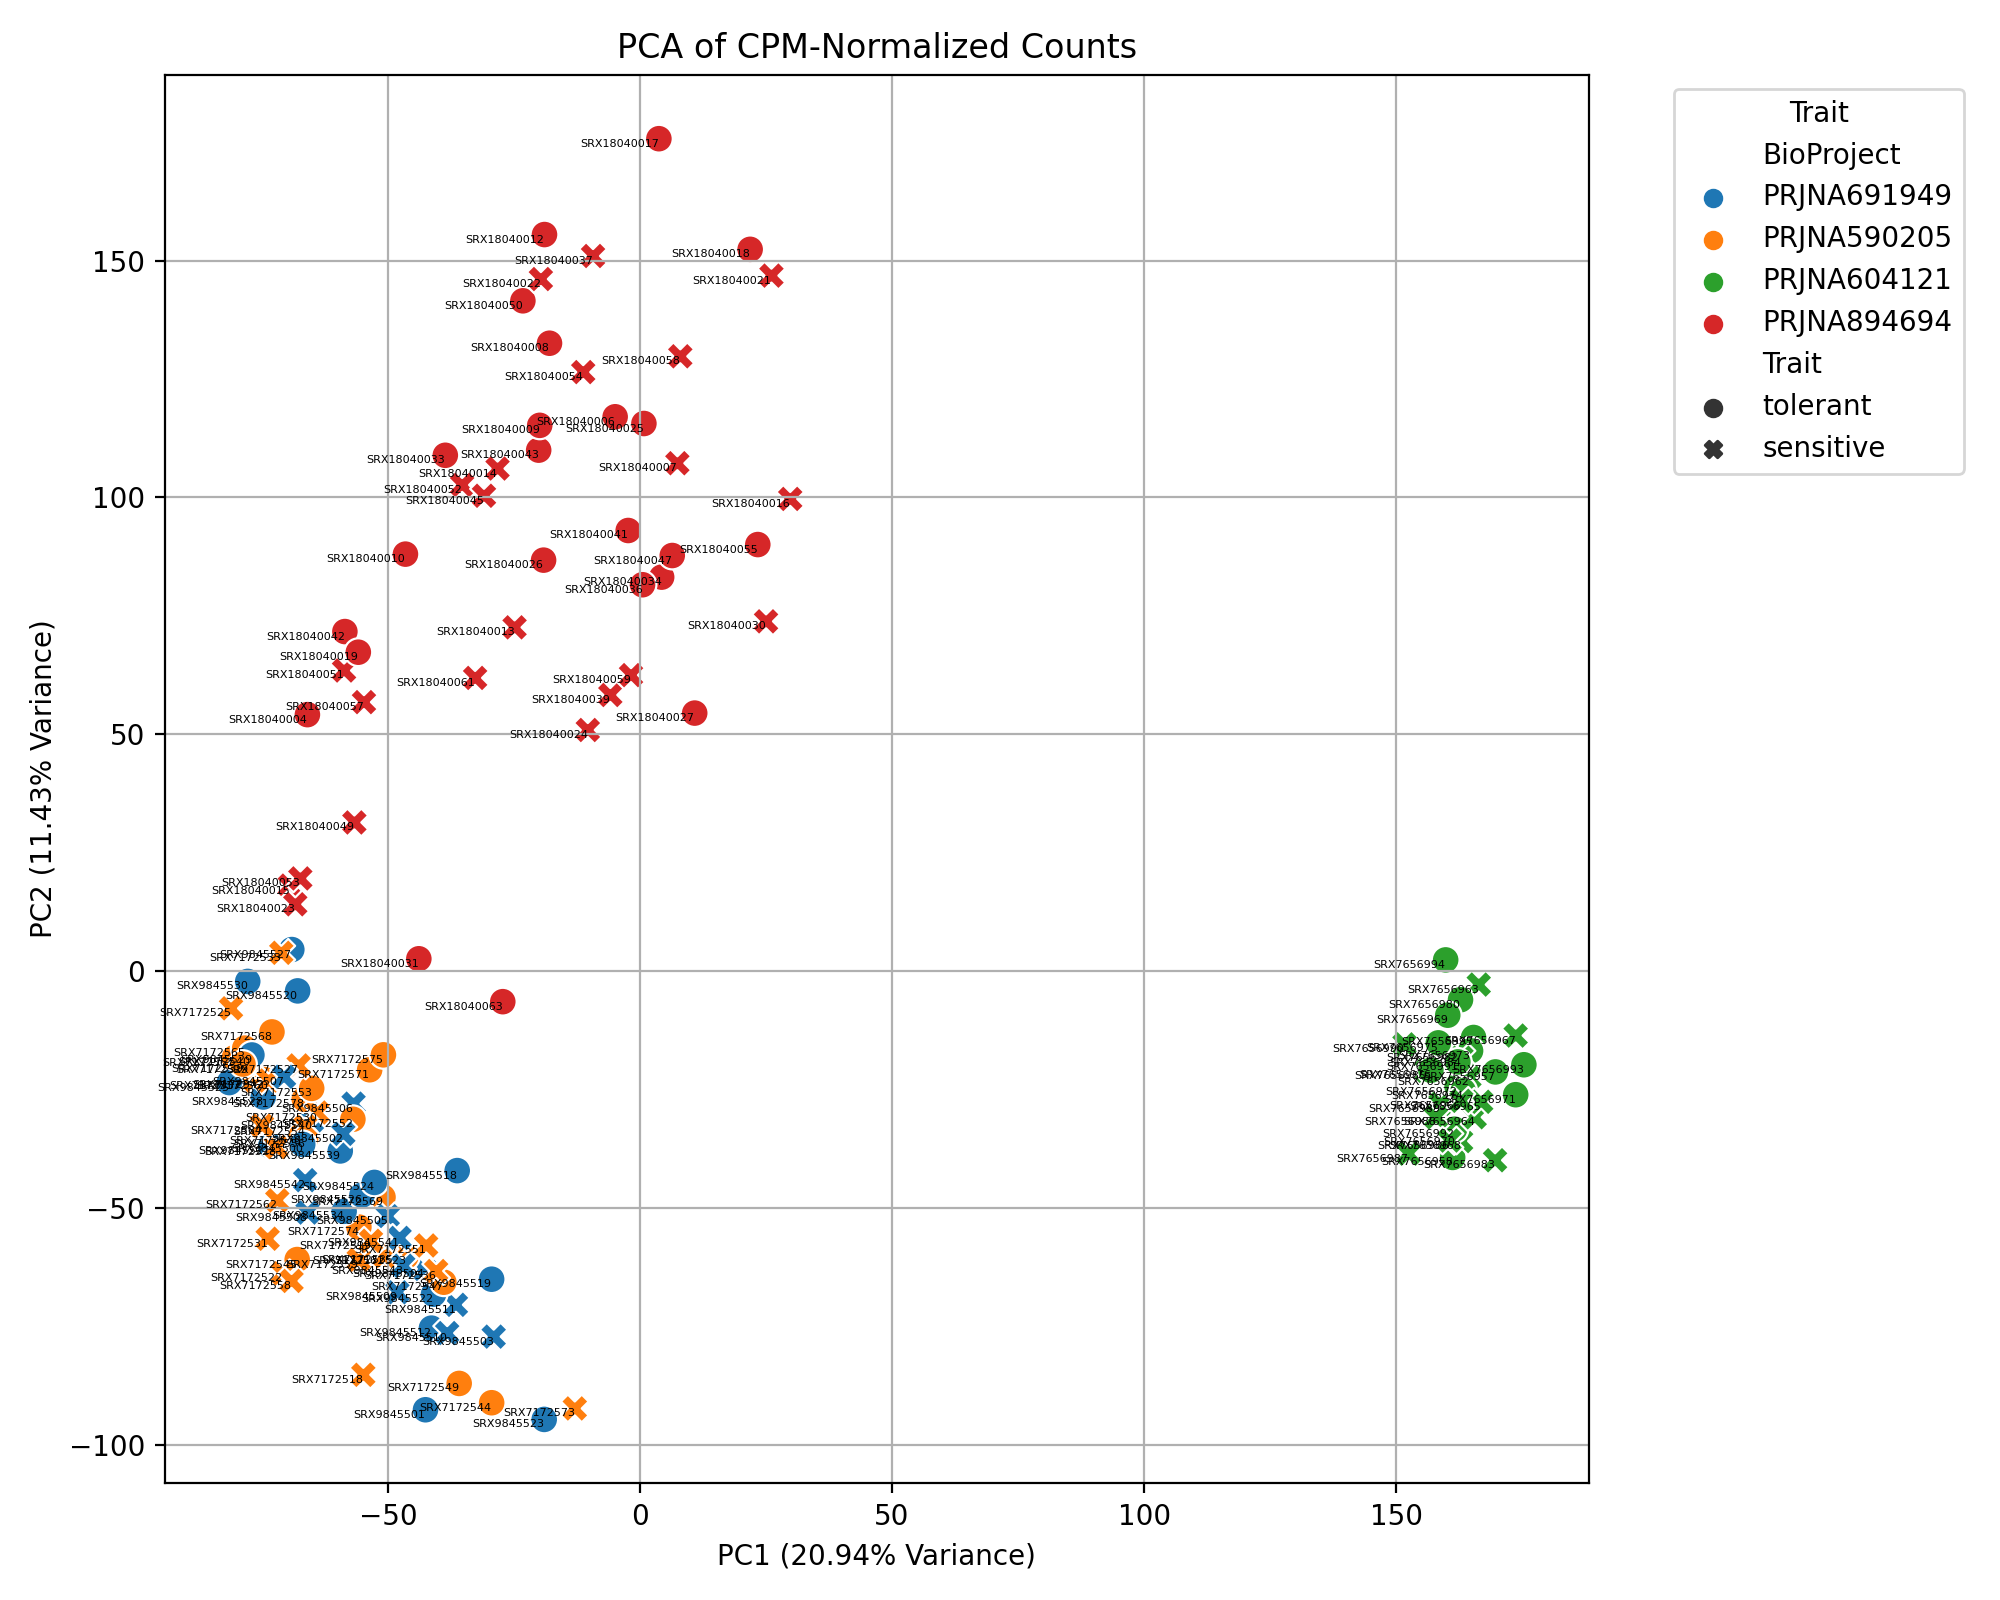

<Figure size 640x480 with 0 Axes>

In [46]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Standardize the data (mean=0, variance=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(np.log10(pca_data + 1))  # Log-transform CPM values

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 principal components
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Sample'] = pca_data.index

# Merge with metadata to color by treatment or batch
pca_df = pd.merge(pca_df, metadata, left_on='Sample', right_on='Sample')

# Plot PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=pca_df, 
    x='PC1', y='PC2', 
    hue='BioProject',  # Color by treatment
    style='Trait',    # Style points by batch
    s=100
)

# Add sample ID annotations
for i, row in pca_df.iterrows():
    plt.text(
        x=row['PC1'], 
        y=row['PC2'], 
        s=row['Sample'], 
        fontsize=4, 
        ha='right', 
        va='top'
    )
    
plt.title('PCA of CPM-Normalized Counts')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)')
plt.legend(title='Trait', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()


plt.savefig("../analyses/2025-01-03_RNAseq_all_AI_diffexp/PCA_all_genes_normCPM.png")

In [76]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import matplotlib

matplotlib.use('Agg')

log_cpm = cpm_values.apply(lambda x: np.log2(x + 1), axis=1)

log_cpm.head()

,0,1,4,5,6,7,8,9,10,11,...,38259,38260,38261,38262,38263,38532,38533,38704,38740,38761
SRX18040024,0.860573,3.117984,3.149897,1.522413,1.255093,3.074288,0.0,3.673617,0.048222,4.844777,...,7.857026,2.551040,3.371175,4.940507,8.093411,0.0,0.0,0.0,0.0,0.0
SRX9845525,1.758992,2.695665,4.178705,1.639733,3.754522,4.107302,0.0,3.997300,1.042525,6.755460,...,2.519407,2.528379,2.389379,4.828991,6.892070,0.0,0.0,0.0,0.0,0.0
SRX9845503,0.668419,2.357640,4.653702,2.419498,3.888957,3.057243,0.0,2.865165,1.247991,5.802388,...,8.497268,1.362637,2.563423,5.394263,8.664874,0.0,0.0,0.0,0.0,0.0
SRX18040046,0.941406,3.568119,1.581342,1.297434,1.748973,2.815468,0.0,4.878218,0.166998,5.291524,...,6.051821,2.002392,2.895845,4.525331,7.172069,0.0,0.0,0.0,0.0,0.0
SRX18040056,0.000000,0.000000,3.551758,1.818545,2.506102,2.190095,0.0,3.725733,0.000000,5.341583,...,7.003350,2.025283,3.259548,4.267946,6.909000,0.0,0.0,0.0,0.0,0.0


In [77]:
#preview the data before log transformation to confirm it worked
log_cpm_T = log_cpm.T
log_cpm_T.head()

,SRX18040024,SRX9845525,SRX9845503,SRX18040046,SRX18040056,SRX13037867,SRX9845524,SRX9845520,SRX18040061,SRX7656993,...,SRX7656977,SRX7656985,SRX9845507,SRX7656986,SRX18040021,SRX18040059,SRX13037868,SRX7656987,SRX13037866,SRX13037870
0,0.860573,1.758992,0.668419,0.941406,0.000000,0.403297,0.000000,0.521970,1.624787,0.000000,...,0.000000,0.000000,0.938984,0.000000,0.000000,0.950678,0.421860,0.942783,1.249800,0.721559
1,3.117984,2.695665,2.357640,3.568119,0.000000,0.161945,3.592048,4.488181,6.160497,0.000000,...,0.000000,0.968527,6.272441,0.806833,3.889783,4.543503,0.000000,0.000000,0.000000,0.000000
4,3.149897,4.178705,4.653702,1.581342,3.551758,2.444818,3.381455,3.245926,3.833335,2.811485,...,1.827631,1.514617,4.662564,2.458435,2.834260,3.476650,2.704887,0.942783,4.362301,3.548490
5,1.522413,1.639733,2.419498,1.297434,1.818545,2.335993,1.529252,0.000000,0.890190,1.324820,...,1.323234,0.968527,0.882398,1.321198,0.000000,0.998034,2.056742,0.942783,0.000000,0.408876
6,1.255093,3.754522,3.888957,1.748973,2.506102,2.619185,2.950082,2.413097,0.847981,2.463374,...,3.135623,3.940413,3.715303,4.422064,1.550596,1.566493,3.207443,3.694604,1.805177,2.996492


In [78]:
# Calculate variance and prepare for mutual information analysis
gene_variances = log_cpm_T.var(axis=1)

# Select the top 50 most variable genes
top_genes = gene_variances.nlargest(50).index
# Subset the log-transformed CPM data for these top genes
top_genes_data = log_cpm_T.loc[top_genes]
#preview output
print(top_genes_data)


       SRX18040024  SRX9845525  SRX9845503  SRX18040046  SRX18040056  \
13418    10.549006   14.231360    8.411317    12.891633    12.981085   
12860     7.814614   13.399327    8.800085    10.229377    10.453531   
2283     10.647827   11.087409   10.255358    11.439858     9.868387   
24020    11.862818   12.834475    9.982848    12.186969    10.026641   
31629    11.329019   11.871966    8.597696    11.680889     9.663807   
25182    11.060153   11.873292    8.322923    11.344139     9.461672   
8131     10.214297   11.632007    8.550435    10.079580     4.952148   
19542     9.758298   11.573142    6.621255    10.178617    10.386631   
16038    10.904822    6.666110    9.500014    13.092714     9.431723   
14747     0.000000    0.000000    0.000000     0.000000     0.000000   
17925    10.065207    9.456574    7.462903    10.884847     9.756352   
20391     2.709679    0.000000    0.000000     2.921169     2.228267   
25668     9.870725   10.996017    8.135505    10.106711     8.88

In [79]:
metadata_sorted = metadata.sort_values(by=['BioProject', 'Trait'])
sorted_samples = metadata_sorted['Sample']

In [80]:
# Subset and reorder the heatmap data to match the sorted samples
top_genes_data_sorted = top_genes_data[sorted_samples]

#preview top_genes_data_sorted
top_genes_data_sorted.head()



,SRX7656990,SRX7656989,SRX7656988,SRX7656987,SRX7656986,SRX7656985,SRX7656984,SRX7656983,SRX7656982,SRX7656968,...,SRX18040019,SRX18040018,SRX18040017,SRX18040012,SRX18040011,SRX18040010,SRX18040009,SRX18040008,SRX18040005,SRX18040004
13418,0.0,0.667171,0.000000,0.942783,0.000000,0.968527,0.000000,0.0,0.685398,0.0,...,14.535182,14.267838,14.540351,15.550726,13.954985,13.451893,14.140120,15.641200,13.924816,15.245658
12860,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.685398,0.0,...,13.385424,12.323629,13.632753,14.423402,13.032163,14.362316,12.154792,11.699844,12.654843,13.430757
2283,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.991209,0.0,0.000000,0.0,...,12.179921,12.250326,11.622152,11.786951,10.734371,11.403177,11.915130,13.496608,12.699713,12.466932
24020,0.0,1.121621,0.829677,0.000000,0.000000,0.000000,0.991209,0.0,0.000000,0.0,...,13.009512,11.899441,11.713367,12.562338,12.244963,13.090606,12.774032,12.675867,10.988661,13.424589
31629,0.0,0.000000,0.000000,0.000000,0.806833,0.968527,0.000000,0.0,0.000000,0.0,...,12.369495,11.279083,11.482471,12.140074,11.886681,12.860895,12.835158,12.288786,11.352765,12.339945


In [81]:
# Calculate mutual information for subsets of 10 genes
sample_metadata = metadata.set_index('Sample')
# Prepare data for mutual information calculation
# Flatten the top genes data for each sample to compare with categorical labels
expression_data = top_genes_data_sorted.T.values  # Shape: (samples, genes)


# Encode thermal tolerance and day as labels for mutual information analysis
labels_resilience_day = metadata_sorted[['BioProject','Trait']]
labels_combined = labels_resilience_day['BioProject'] + "-Trait" + \
    labels_resilience_day['Trait'].astype(str)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels_combined)

# Calculate mutual information multiple times and average, because
# it's a stochastic algorithm
mi_scores_list = []
n_repeats = 5
for _ in range(n_repeats):
    mi_scores = mutual_info_classif(expression_data, encoded_labels,
                                    discrete_features=False,
                                    # Each repetition uses a different
                                    # random initialization
                                    random_state=None)
    mi_scores_list.append(mi_scores)

avg_mi_scores = np.mean(mi_scores_list, axis=0)

In [82]:
# Create a DataFrame for averaged results
mutual_info_results = pd.DataFrame({
    'Gene': top_genes_data_sorted.index,
    'Mutual_Information': avg_mi_scores
}).sort_values(by='Mutual_Information', ascending=False)

print(mutual_info_results.head(10))

     Gene  Mutual_Information
42  19340            1.198932
23  23654            1.081305
11  20391            0.980754
39  21241            0.949565
2    2283            0.842212
16  10161            0.838332
7   19542            0.832826
46  17436            0.820358
8   16038            0.802421
34  31664            0.799587


In [83]:
# Do PCA plot for the top 10, genes in mutual information score
top_genes_to_visualize = mutual_info_results.iloc[:10]['Gene']

# Subset the log-transformed CPM data for these genes
top_genes_data = log_cpm_T.loc[top_genes_to_visualize]

top_genes_data.head()

,SRX18040024,SRX9845525,SRX9845503,SRX18040046,SRX18040056,SRX13037867,SRX9845524,SRX9845520,SRX18040061,SRX7656993,...,SRX7656977,SRX7656985,SRX9845507,SRX7656986,SRX18040021,SRX18040059,SRX13037868,SRX7656987,SRX13037866,SRX13037870
19340,11.568704,10.665900,10.636814,11.564167,11.406112,9.088227,10.493663,10.261501,11.470916,0.000000,...,0.000000,0.000000,10.861138,2.802752,6.051663,11.218091,9.303812,0.000000,10.754342,9.014093
23654,10.431148,8.969714,6.388147,11.362789,10.972430,9.584619,9.416869,9.125449,10.746945,0.000000,...,0.000000,0.000000,8.412652,0.000000,11.549802,10.811635,9.881950,0.000000,11.459941,9.874915
20391,2.709679,0.000000,0.000000,2.921169,2.228267,0.000000,1.758998,1.883803,2.442550,12.125156,...,11.619054,11.831614,2.664606,11.503915,2.163753,2.693118,5.199951,11.390634,10.745323,6.597908
21241,11.762421,11.128956,10.971307,11.543657,11.617853,9.193739,11.145371,10.991775,11.782363,5.403430,...,0.000000,4.739429,11.622067,4.399293,12.628166,11.571750,9.674665,6.221294,10.040375,9.785100
2283,10.647827,11.087409,10.255358,11.439858,9.868387,0.945431,11.552222,10.474216,12.633599,0.000000,...,0.000000,0.000000,11.800609,0.000000,9.926230,11.080604,0.000000,0.000000,2.528049,0.526479


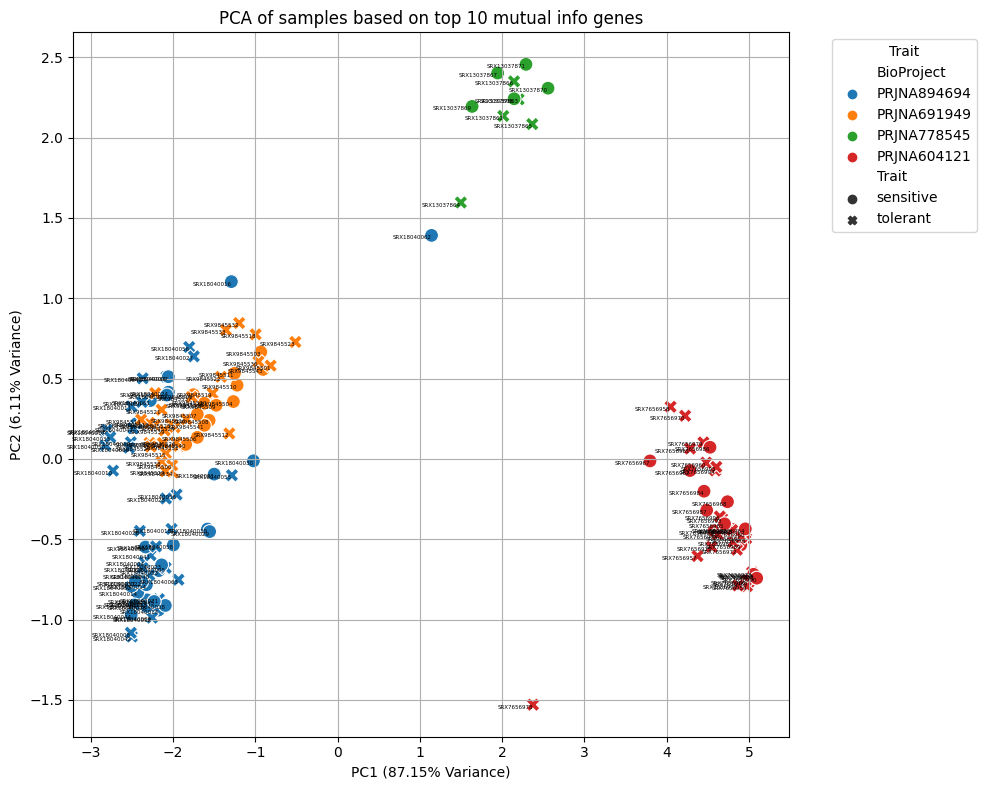

In [84]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Perform PCA for the top 10 genes
pca_data = top_genes_data.T

scaler = StandardScaler()
scaled_top_10_data = scaler.fit_transform(top_genes_data.T)  # Transpose so genes are features
pca_top_10 = PCA(n_components=2)
principal_components = pca_top_10.fit_transform(scaled_top_10_data)



# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Sample'] = pca_data.index

# Merge with metadata to color by treatment or batch
pca_df = pd.merge(pca_df, metadata, left_on='Sample', right_on='Sample')

# Plot PCA for Top 10 Genes
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=pca_df, 
    x='PC1', y='PC2', 
    hue='BioProject',  # Color by treatment
    style='Trait',    # Style points by batch
    s=100
)

# Add sample ID annotations
for i, row in pca_df.iterrows():
    plt.text(
        x=row['PC1'], 
        y=row['PC2'], 
        s=row['Sample'], 
        fontsize=4, 
        ha='right', 
        va='top'
    )
    
plt.title('PCA of samples based on top 10 mutual info genes')
plt.xlabel(f'PC1 ({pca_top_10.explained_variance_ratio_[0]*100:.2f}% Variance)')
plt.ylabel(f'PC2 ({pca_top_10.explained_variance_ratio_[1]*100:.2f}% Variance)')
plt.legend(title='Trait', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()

plt.savefig("../analyses/2025-01-03_RNAseq_all_AI_diffexp/PCA_top_10_mutual_info_genes.png")

It appears the effect from experiment is much greater than the effect from trait. Let's see if we can get resolution if we ask the mutual information analysis to just focus on trait and ignore experiment

In [85]:
# Calculate mutual information for subsets of 10 genes
sample_metadata = metadata.set_index('Sample')
# Prepare data for mutual information calculation
# Flatten the top genes data for each sample to compare with categorical labels
expression_data = top_genes_data_sorted.T.values  # Shape: (samples, genes)


# Encode thermal tolerance and day as labels for mutual information analysis
labels_resilience_day = metadata_sorted[['Trait']]
labels_combined = labels_resilience_day['Trait']
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels_combined)

# Calculate mutual information multiple times and average, because
# it's a stochastic algorithm
mi_scores_list = []
n_repeats = 5
for _ in range(n_repeats):
    mi_scores = mutual_info_classif(expression_data, encoded_labels,
                                    discrete_features=False,
                                    # Each repetition uses a different
                                    # random initialization
                                    random_state=None)
    mi_scores_list.append(mi_scores)

avg_mi_scores = np.mean(mi_scores_list, axis=0)

In [86]:
# Create a DataFrame for averaged results
mutual_info_results = pd.DataFrame({
    'Gene': top_genes_data_sorted.index,
    'Mutual_Information': avg_mi_scores
}).sort_values(by='Mutual_Information', ascending=False)

print(mutual_info_results.head(10))

     Gene  Mutual_Information
13  17832            0.098989
12  25668            0.079557
30  32683            0.065978
42  19340            0.062957
28  30124            0.060187
2    2283            0.054371
31  28726            0.052483
48  36451            0.038756
15  13815            0.036269
26  33623            0.033635


In [87]:
# Do PCA plot for the top 10, genes in mutual information score
top_genes_to_visualize = mutual_info_results.iloc[:10]['Gene']

# Subset the log-transformed CPM data for these genes
top_genes_data = log_cpm_T.loc[top_genes_to_visualize]

top_genes_data.head()

,SRX18040024,SRX9845525,SRX9845503,SRX18040046,SRX18040056,SRX13037867,SRX9845524,SRX9845520,SRX18040061,SRX7656993,...,SRX7656977,SRX7656985,SRX9845507,SRX7656986,SRX18040021,SRX18040059,SRX13037868,SRX7656987,SRX13037866,SRX13037870
17832,8.998482,10.137681,9.174322,9.989492,9.404664,0.000000,8.759952,9.710982,9.085239,0.000000,...,0.0,0.000000,10.608365,0.000000,7.746653,8.632870,0.000000,0.942783,0.000000,0.000000
25668,9.870725,10.996017,8.135505,10.106711,8.884303,0.161945,10.357199,8.984393,9.935916,0.000000,...,0.0,0.000000,9.232515,0.806833,9.947959,9.808742,0.359670,0.000000,0.000000,0.000000
32683,7.906383,9.657372,7.237319,8.666993,6.615376,0.439764,9.498579,10.992754,8.853408,0.000000,...,0.0,0.000000,10.960938,0.000000,6.220795,8.072755,0.336728,0.000000,0.000000,0.123372
19340,11.568704,10.665900,10.636814,11.564167,11.406112,9.088227,10.493663,10.261501,11.470916,0.000000,...,0.0,0.000000,10.861138,2.802752,6.051663,11.218091,9.303812,0.000000,10.754342,9.014093
30124,10.224886,8.590411,5.523109,13.101016,7.569514,0.776328,10.205545,11.348923,13.204597,2.003614,...,0.0,2.752973,11.324778,0.000000,8.442265,11.832168,0.000000,1.508158,0.000000,0.000000


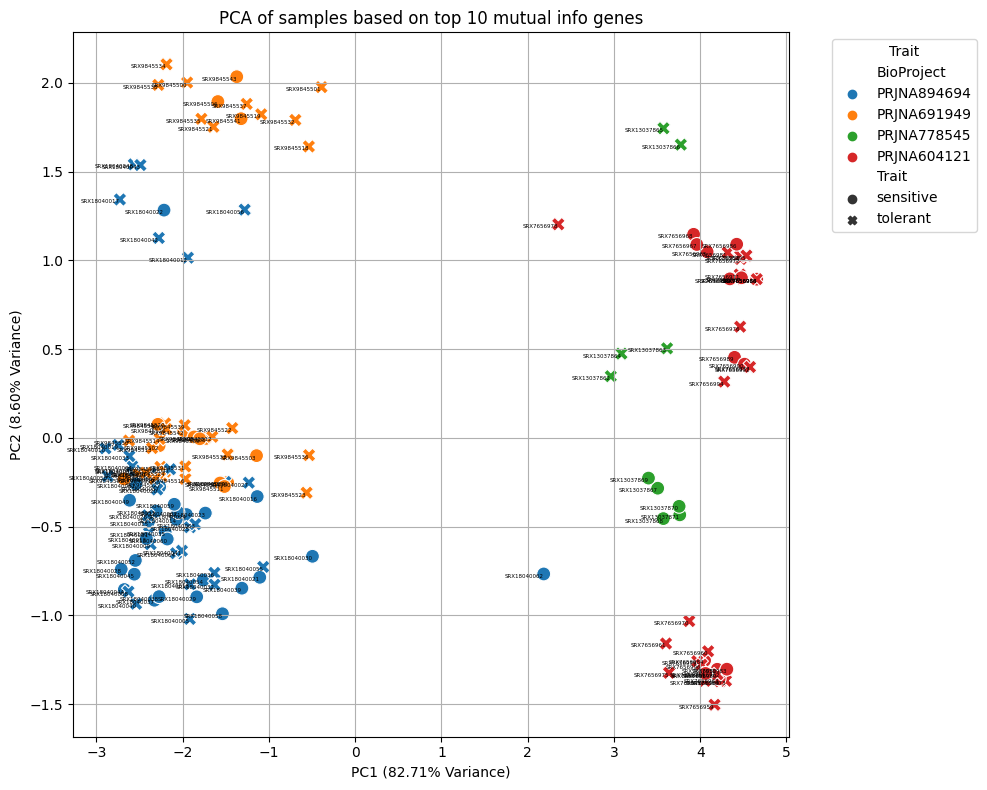

In [88]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Perform PCA for the top 10 genes
pca_data = top_genes_data.T

scaler = StandardScaler()
scaled_top_10_data = scaler.fit_transform(top_genes_data.T)  # Transpose so genes are features
pca_top_10 = PCA(n_components=3)
principal_components = pca_top_10.fit_transform(scaled_top_10_data)



# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2','PC3'])
pca_df['Sample'] = pca_data.index

# Merge with metadata to color by treatment or batch
pca_df = pd.merge(pca_df, metadata, left_on='Sample', right_on='Sample')

# Plot PCA for Top 10 Genes
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=pca_df, 
    x='PC1', y='PC2', 
    hue='BioProject',  # Color by treatment
    style='Trait',    # Style points by batch
    s=100
)

# Add sample ID annotations
for i, row in pca_df.iterrows():
    plt.text(
        x=row['PC1'], 
        y=row['PC2'], 
        s=row['Sample'], 
        fontsize=4, 
        ha='right', 
        va='top'
    )
    
plt.title('PCA of samples based on top 10 mutual info genes')
plt.xlabel(f'PC1 ({pca_top_10.explained_variance_ratio_[0]*100:.2f}% Variance)')
plt.ylabel(f'PC2 ({pca_top_10.explained_variance_ratio_[1]*100:.2f}% Variance)')
plt.legend(title='Trait', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()

plt.savefig("../analyses/2025-01-03_RNAseq_all_AI_diffexp/PCA_top_10_mutual_info_genes.png")

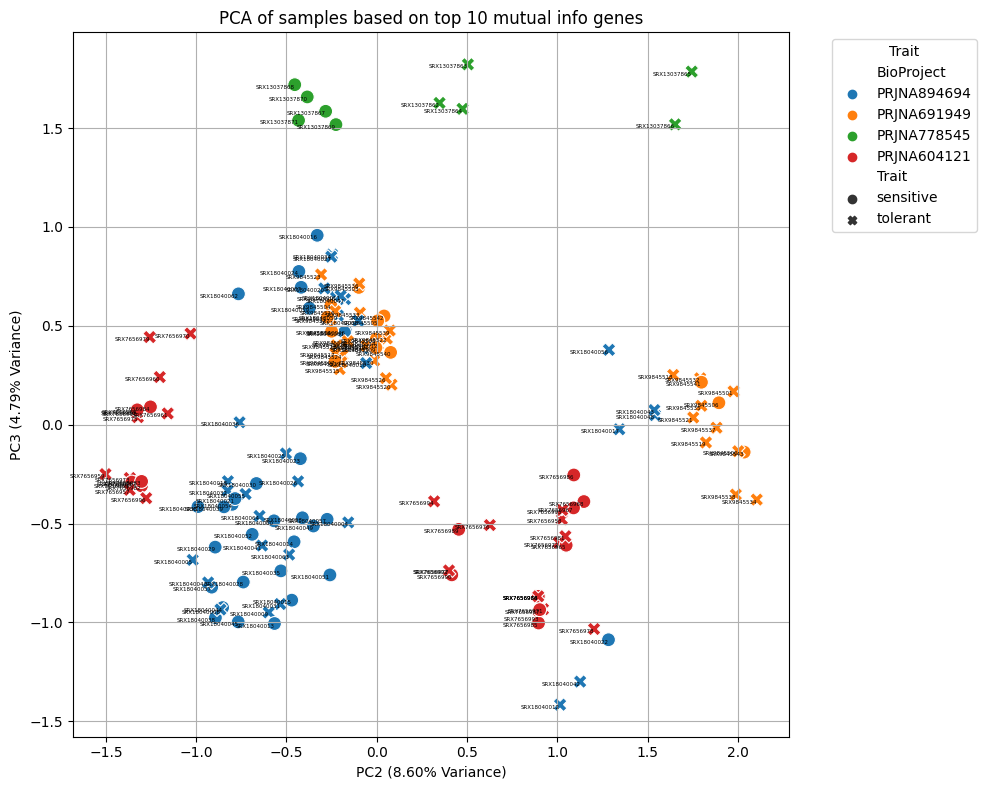

In [90]:
# Plot PC2 and 3 for Top 10 Genes (from analysis of top 50 most variable genes)
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=pca_df, 
    x='PC2', y='PC3', 
    hue='BioProject',  # Color by treatment
    style='Trait',    # Style points by batch
    s=100
)

# Add sample ID annotations
for i, row in pca_df.iterrows():
    plt.text(
        x=row['PC2'], 
        y=row['PC3'], 
        s=row['Sample'], 
        fontsize=4, 
        ha='right', 
        va='top'
    )
    
plt.title('PCA of samples based on top 10 mutual info genes')
plt.xlabel(f'PC2 ({pca_top_10.explained_variance_ratio_[1]*100:.2f}% Variance)')
plt.ylabel(f'PC3 ({pca_top_10.explained_variance_ratio_[2]*100:.2f}% Variance)')
plt.legend(title='Trait', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

there still doesn't seem to be separation between traits after only focusing on the trait parameter. What happens if we select the top 500 genes instead of the top 50?

In [91]:
# Calculate variance and prepare for mutual information analysis
gene_variances = log_cpm_T.var(axis=1)

# Select the top 500 most variable genes
top_genes = gene_variances.nlargest(500).index
# Subset the log-transformed CPM data for these top genes
top_genes_data = log_cpm_T.loc[top_genes]
#preview output
print(top_genes_data)

       SRX18040024  SRX9845525  SRX9845503  SRX18040046  SRX18040056  \
13418    10.549006   14.231360    8.411317    12.891633    12.981085   
12860     7.814614   13.399327    8.800085    10.229377    10.453531   
2283     10.647827   11.087409   10.255358    11.439858     9.868387   
24020    11.862818   12.834475    9.982848    12.186969    10.026641   
31629    11.329019   11.871966    8.597696    11.680889     9.663807   
...            ...         ...         ...          ...          ...   
16330     2.146719    0.000000    0.478078     1.654252     4.583580   
11193     7.769204    3.298683    6.715974     7.017782     3.220461   
4559      1.690554    1.505014    3.986174     4.057555     6.245675   
23123     5.662757    8.280771    5.686108     6.508034     4.508412   
32610     1.868378    4.123282    2.903546     1.934539     2.540486   

       SRX13037867  SRX9845524  SRX9845520  SRX18040061  SRX7656993  ...  \
13418     2.913356   14.291184   12.145946    13.132682    

In [92]:
metadata_sorted = metadata.sort_values(by=['BioProject', 'Trait'])
sorted_samples = metadata_sorted['Sample']

In [93]:
# Subset and reorder the heatmap data to match the sorted samples
top_genes_data_sorted = top_genes_data[sorted_samples]

#preview top_genes_data_sorted
top_genes_data_sorted.head()

,SRX7656990,SRX7656989,SRX7656988,SRX7656987,SRX7656986,SRX7656985,SRX7656984,SRX7656983,SRX7656982,SRX7656968,...,SRX18040019,SRX18040018,SRX18040017,SRX18040012,SRX18040011,SRX18040010,SRX18040009,SRX18040008,SRX18040005,SRX18040004
13418,0.0,0.667171,0.000000,0.942783,0.000000,0.968527,0.000000,0.0,0.685398,0.0,...,14.535182,14.267838,14.540351,15.550726,13.954985,13.451893,14.140120,15.641200,13.924816,15.245658
12860,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.685398,0.0,...,13.385424,12.323629,13.632753,14.423402,13.032163,14.362316,12.154792,11.699844,12.654843,13.430757
2283,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.991209,0.0,0.000000,0.0,...,12.179921,12.250326,11.622152,11.786951,10.734371,11.403177,11.915130,13.496608,12.699713,12.466932
24020,0.0,1.121621,0.829677,0.000000,0.000000,0.000000,0.991209,0.0,0.000000,0.0,...,13.009512,11.899441,11.713367,12.562338,12.244963,13.090606,12.774032,12.675867,10.988661,13.424589
31629,0.0,0.000000,0.000000,0.000000,0.806833,0.968527,0.000000,0.0,0.000000,0.0,...,12.369495,11.279083,11.482471,12.140074,11.886681,12.860895,12.835158,12.288786,11.352765,12.339945


In [94]:
# Calculate mutual information for subsets of 10 genes
sample_metadata = metadata.set_index('Sample')
# Prepare data for mutual information calculation
# Flatten the top genes data for each sample to compare with categorical labels
expression_data = top_genes_data_sorted.T.values  # Shape: (samples, genes)


# Encode thermal tolerance and day as labels for mutual information analysis
labels_resilience_day = metadata_sorted[['Trait']]
labels_combined = labels_resilience_day['Trait']
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels_combined)

# Calculate mutual information multiple times and average, because
# it's a stochastic algorithm
mi_scores_list = []
n_repeats = 50
for _ in range(n_repeats):
    mi_scores = mutual_info_classif(expression_data, encoded_labels,
                                    discrete_features=False,
                                    # Each repetition uses a different
                                    # random initialization
                                    random_state=None)
    mi_scores_list.append(mi_scores)

avg_mi_scores = np.mean(mi_scores_list, axis=0)

In [96]:
# Create a DataFrame for averaged results
mutual_info_results = pd.DataFrame({
    'Gene': top_genes_data_sorted.index,
    'Mutual_Information': avg_mi_scores
}).sort_values(by='Mutual_Information', ascending=False)

print(mutual_info_results.head(10))

      Gene  Mutual_Information
211  17590            0.191470
416   2570            0.164688
446  27119            0.162414
466  34478            0.133297
323  18810            0.129636
362   8590            0.129438
92    3245            0.111709
149   1439            0.109773
490   2399            0.107807
329  10092            0.104658


In [97]:
# Do PCA plot for the top 10, genes in mutual information score
top_genes_to_visualize = mutual_info_results.iloc[:10]['Gene']

# Subset the log-transformed CPM data for these genes
top_genes_data = log_cpm_T.loc[top_genes_to_visualize]

top_genes_data.head()

,SRX18040024,SRX9845525,SRX9845503,SRX18040046,SRX18040056,SRX13037867,SRX9845524,SRX9845520,SRX18040061,SRX7656993,...,SRX7656977,SRX7656985,SRX9845507,SRX7656986,SRX18040021,SRX18040059,SRX13037868,SRX7656987,SRX13037866,SRX13037870
17590,5.806370,6.877514,6.606646,0.634351,7.817194,5.729354,6.542877,5.824050,0.783585,7.641418,...,11.635909,11.772391,6.537625,11.180058,6.519766,6.731604,5.730380,11.157630,0.000000,5.755388
2570,4.475327,0.000000,0.000000,0.000000,0.000000,2.141824,0.000000,0.000000,0.000000,0.000000,...,9.173527,0.968527,0.000000,6.217967,2.749481,0.000000,2.321586,7.584227,4.046896,2.087824
27119,1.827514,0.000000,0.000000,0.986782,0.000000,7.523004,0.000000,0.000000,0.530011,0.000000,...,0.000000,0.000000,0.000000,0.000000,6.099716,1.873848,7.194129,0.000000,0.000000,7.245390
34478,4.333585,6.766829,7.193913,4.045463,4.666821,6.406352,6.552424,5.842912,3.355042,0.000000,...,0.000000,0.000000,7.161639,0.000000,2.950482,4.419026,6.486715,0.000000,5.943321,6.251120
18810,6.176143,0.000000,5.881440,5.526682,7.543956,3.288146,0.000000,0.000000,3.596757,6.134032,...,6.066187,5.581509,6.275987,5.719905,0.640170,4.330703,2.796936,6.188523,0.000000,3.459180


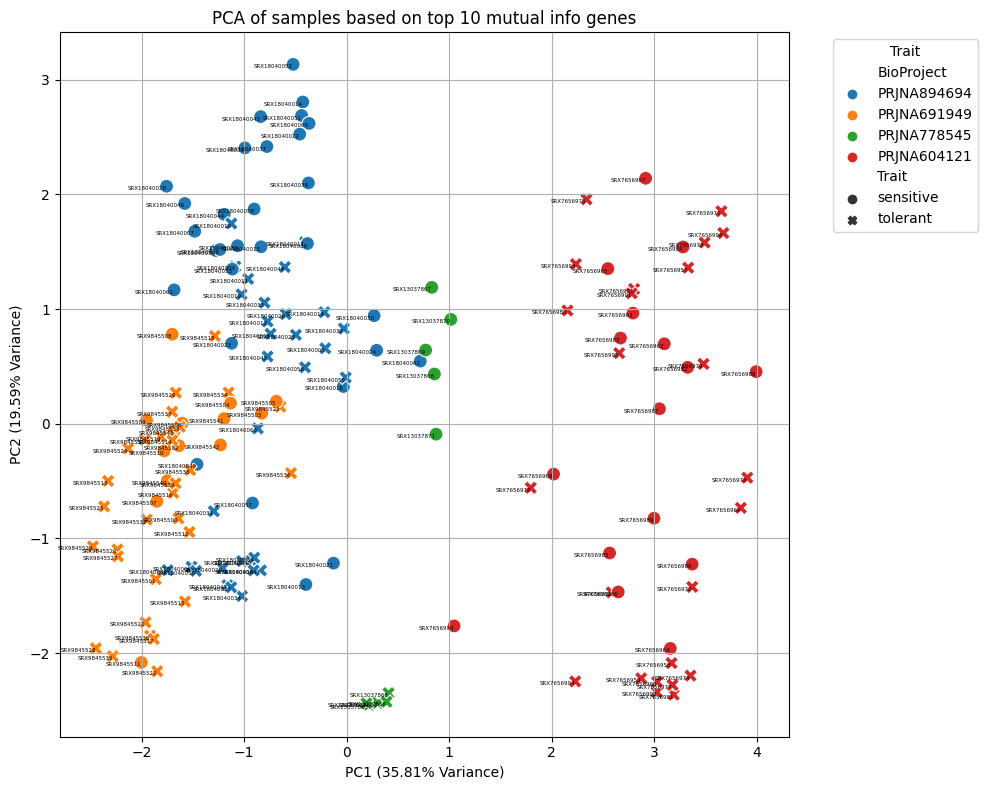

In [98]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Perform PCA for the top 10 genes
pca_data = top_genes_data.T

scaler = StandardScaler()
scaled_top_10_data = scaler.fit_transform(top_genes_data.T)  # Transpose so genes are features
pca_top_10 = PCA(n_components=2)
principal_components = pca_top_10.fit_transform(scaled_top_10_data)



# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Sample'] = pca_data.index

# Merge with metadata to color by treatment or batch
pca_df = pd.merge(pca_df, metadata, left_on='Sample', right_on='Sample')

# Plot PCA for Top 10 Genes
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=pca_df, 
    x='PC1', y='PC2', 
    hue='BioProject',  # Color by treatment
    style='Trait',    # Style points by batch
    s=100
)

# Add sample ID annotations
for i, row in pca_df.iterrows():
    plt.text(
        x=row['PC1'], 
        y=row['PC2'], 
        s=row['Sample'], 
        fontsize=4, 
        ha='right', 
        va='top'
    )
    
plt.title('PCA of samples based on top 10 mutual info genes')
plt.xlabel(f'PC1 ({pca_top_10.explained_variance_ratio_[0]*100:.2f}% Variance)')
plt.ylabel(f'PC2 ({pca_top_10.explained_variance_ratio_[1]*100:.2f}% Variance)')
plt.legend(title='Trait', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()

plt.savefig("../analyses/2025-01-03_RNAseq_all_AI_diffexp/PCA_top_10_mutual_info_genes.png")

In [ ]:
this gets a little more separation of samples but there is still so much variation from the experiments (PC1). I wonder what the other PCs looks like?

In [99]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Perform PCA for the top 10 genes
pca_data = top_genes_data.T

scaler = StandardScaler()
scaled_top_10_data = scaler.fit_transform(top_genes_data.T)  # Transpose so genes are features
pca_top_10 = PCA(n_components=5)
principal_components = pca_top_10.fit_transform(scaled_top_10_data)

print(pca_top_10)
print(principal_components)

PCA(n_components=5)
[[ 2.91854274e-01  6.40416230e-01 -4.46497267e-01  8.54163960e-01
   2.96011191e-01]
 [-2.36475303e+00 -7.20972299e-01  8.05321627e-01 -1.04793955e+00
  -4.21697011e-01]
 [-8.28715178e-01  9.15121469e-02 -4.78366011e-01 -4.34998919e-01
   2.96020578e-01]
 [-1.57841364e+00  1.92046993e+00  7.40961655e-01 -3.74393421e-01
  -8.48363232e-01]
 [-4.06439733e-01  4.91707642e-01 -1.57372423e+00  6.66259821e-02
   3.23985553e-01]
 [ 8.29475201e-01  1.18881565e+00  2.69169006e+00 -2.36606176e-01
  -1.09256566e+00]
 [-2.13045582e+00 -2.16449901e-01  9.64442352e-01 -1.25187434e+00
  -2.79210582e-01]
 [-2.23550031e+00 -1.09630428e+00  9.29148083e-01 -8.08875455e-01
  -4.97187854e-01]
 [-1.68277633e+00  1.16722585e+00  7.73898480e-01 -1.00580288e-01
  -3.21942511e-01]
 [ 2.23434536e+00  1.39153089e+00 -7.59311108e-01 -1.05046061e+00
   1.01313744e+00]
 [-4.95400089e-01  7.75094144e-01 -1.78836209e+00  1.74183076e-01
   3.42853855e-01]
 [ 8.71326028e-01 -9.08161585e-02  2.91897009

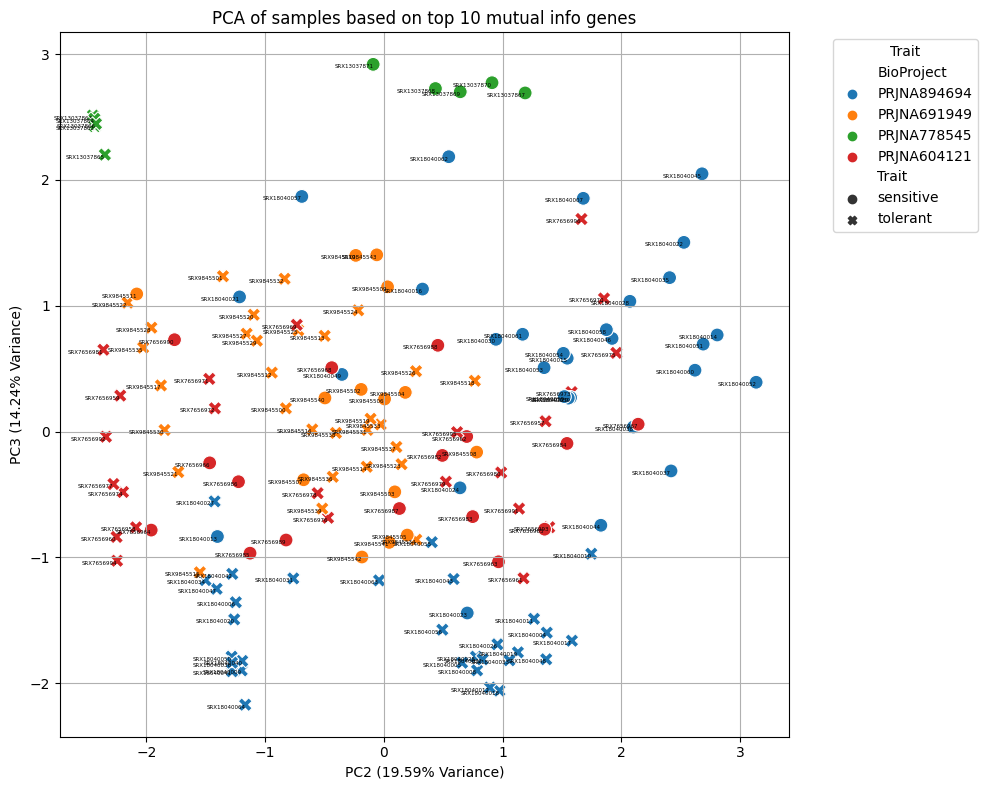

In [100]:
#plot PC2 and PC3

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1','PC2', 'PC3','PC4','PC5'])
pca_df['Sample'] = pca_data.index

# Merge with metadata to color by treatment or batch
pca_df = pd.merge(pca_df, metadata, left_on='Sample', right_on='Sample')

# Plot PCA for Top 10 Genes
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=pca_df, 
    x='PC2', y='PC3', 
    hue='BioProject',  # Color by treatment
    style='Trait',    # Style points by batch
    s=100
)

# Add sample ID annotations
for i, row in pca_df.iterrows():
    plt.text(
        x=row['PC2'], 
        y=row['PC3'], 
        s=row['Sample'], 
        fontsize=4, 
        ha='right', 
        va='top'
    )
    
plt.title('PCA of samples based on top 10 mutual info genes')
plt.xlabel(f'PC2 ({pca_top_10.explained_variance_ratio_[1]*100:.2f}% Variance)')
plt.ylabel(f'PC3 ({pca_top_10.explained_variance_ratio_[2]*100:.2f}% Variance)')
plt.legend(title='Trait', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

this almost works! If you draw a line along the diagonal top left to bottom right. I'll check some other components for curiosity sake

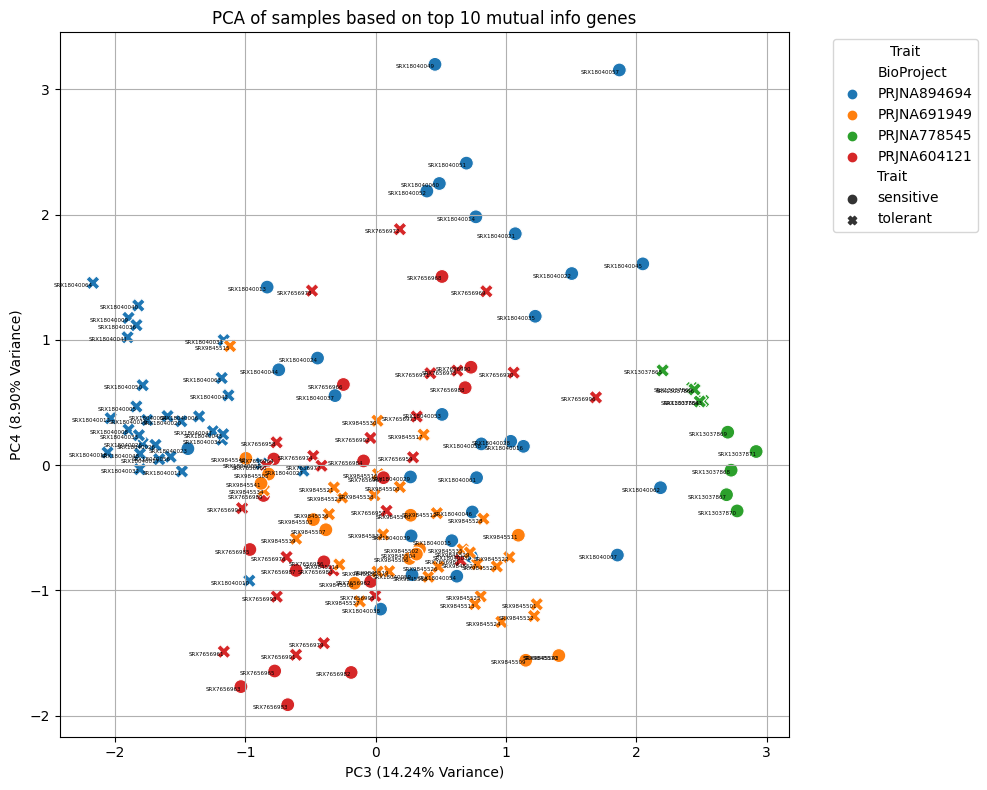

In [62]:
#plot PC3 and PC4
# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1','PC2', 'PC3','PC4','PC5'])
pca_df['Sample'] = pca_data.index

# Merge with metadata to color by treatment or batch
pca_df = pd.merge(pca_df, metadata, left_on='Sample', right_on='Sample')

# Plot PCA for Top 10 Genes
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=pca_df, 
    x='PC3', y='PC4', 
    hue='BioProject',  # Color by treatment
    style='Trait',    # Style points by batch
    s=100
)

# Add sample ID annotations
for i, row in pca_df.iterrows():
    plt.text(
        x=row['PC3'], 
        y=row['PC4'], 
        s=row['Sample'], 
        fontsize=4, 
        ha='right', 
        va='top'
    )
    
plt.title('PCA of samples based on top 10 mutual info genes')
plt.xlabel(f'PC3 ({pca_top_10.explained_variance_ratio_[2]*100:.2f}% Variance)')
plt.ylabel(f'PC4 ({pca_top_10.explained_variance_ratio_[3]*100:.2f}% Variance)')
plt.legend(title='Trait', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()

plt.savefig("../analyses/2025-01-03_RNAseq_all_AI_diffexp/PCA_top_10_mutual_info_genes.png")

In [121]:
# Extract PC loadings
pc_loadings = pd.DataFrame(pca_top_10.components_.T, 
                           index=pca_data.columns, 
                           columns=[f'PC{i+1}' for i in range(pca_top_10.n_components_)])
print("PC Loadings:")
print(pc_loadings)

PC Loadings:
            PC1       PC2       PC3       PC4       PC5
17590  0.283363 -0.151067 -0.386169 -0.426099 -0.202002
2570   0.385194 -0.109851  0.195560  0.143744 -0.163394
27119  0.160606  0.269451  0.386070  0.569040 -0.346168
34478 -0.443682 -0.105781  0.179414 -0.161363  0.060826
18810  0.176732  0.139126 -0.600612  0.209978 -0.455759
8590  -0.267937 -0.049600  0.326621 -0.407488 -0.758983
3245  -0.456724  0.147060 -0.254414  0.193409 -0.094286
1439   0.213019  0.589123  0.006932 -0.370742  0.067265
2399  -0.043760  0.681087  0.089209 -0.161428  0.089895
10092 -0.435626  0.164107 -0.302063  0.192043 -0.060816


In [122]:
# Save theloadings data to a new file
pc_loadings.to_csv("../analyses/2025-01-03_RNAseq_all_AI_diffexp/MI500trait_top10genes.csv", index=False)

In [128]:
sub_cpm_data = cpm_long_format[cpm_long_format['Gene'].isin(pca_data.columns)]
print(sub_cpm_data)

              Sample infection                     BREED    treatment  \
216690   SRX18040064       NaN   ABC_VIMS_Family_2017084  Dose 1x10^6   
216691   SRX18040063       NaN   ABC_VIMS_Family_2017084      Control   
216692   SRX18040062       NaN   ABC_VIMS_Family_2017120  Dose 1x10^6   
216693   SRX18040061       NaN   ABC_VIMS_Family_2017120  Dose 1x10^8   
216694   SRX18040060       NaN   ABC_VIMS_Family_2017090  Dose 1x10^6   
...              ...       ...                       ...          ...   
5164130   SRX9845517       NaN  ABC_VIMS_Family_2014_286          Fed   
5164131   SRX9845516       NaN  ABC_VIMS_Family_2014_286          Fed   
5164132   SRX9845515       NaN  ABC_VIMS_Family_2014_286          Fed   
5164133   SRX9845514       NaN  ABC_VIMS_Family_2014_286          Fed   
5164134   SRX9845513       NaN  ABC_VIMS_Family_2014_286          Fed   

             Trait  tissue  collection_time Collection_Date   BioProject  \
216690    tolerant  mantle              NaN    

/home/shellytrigg/bin/anaconda3/lib/python3.8/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 371 rows containing non-finite values.


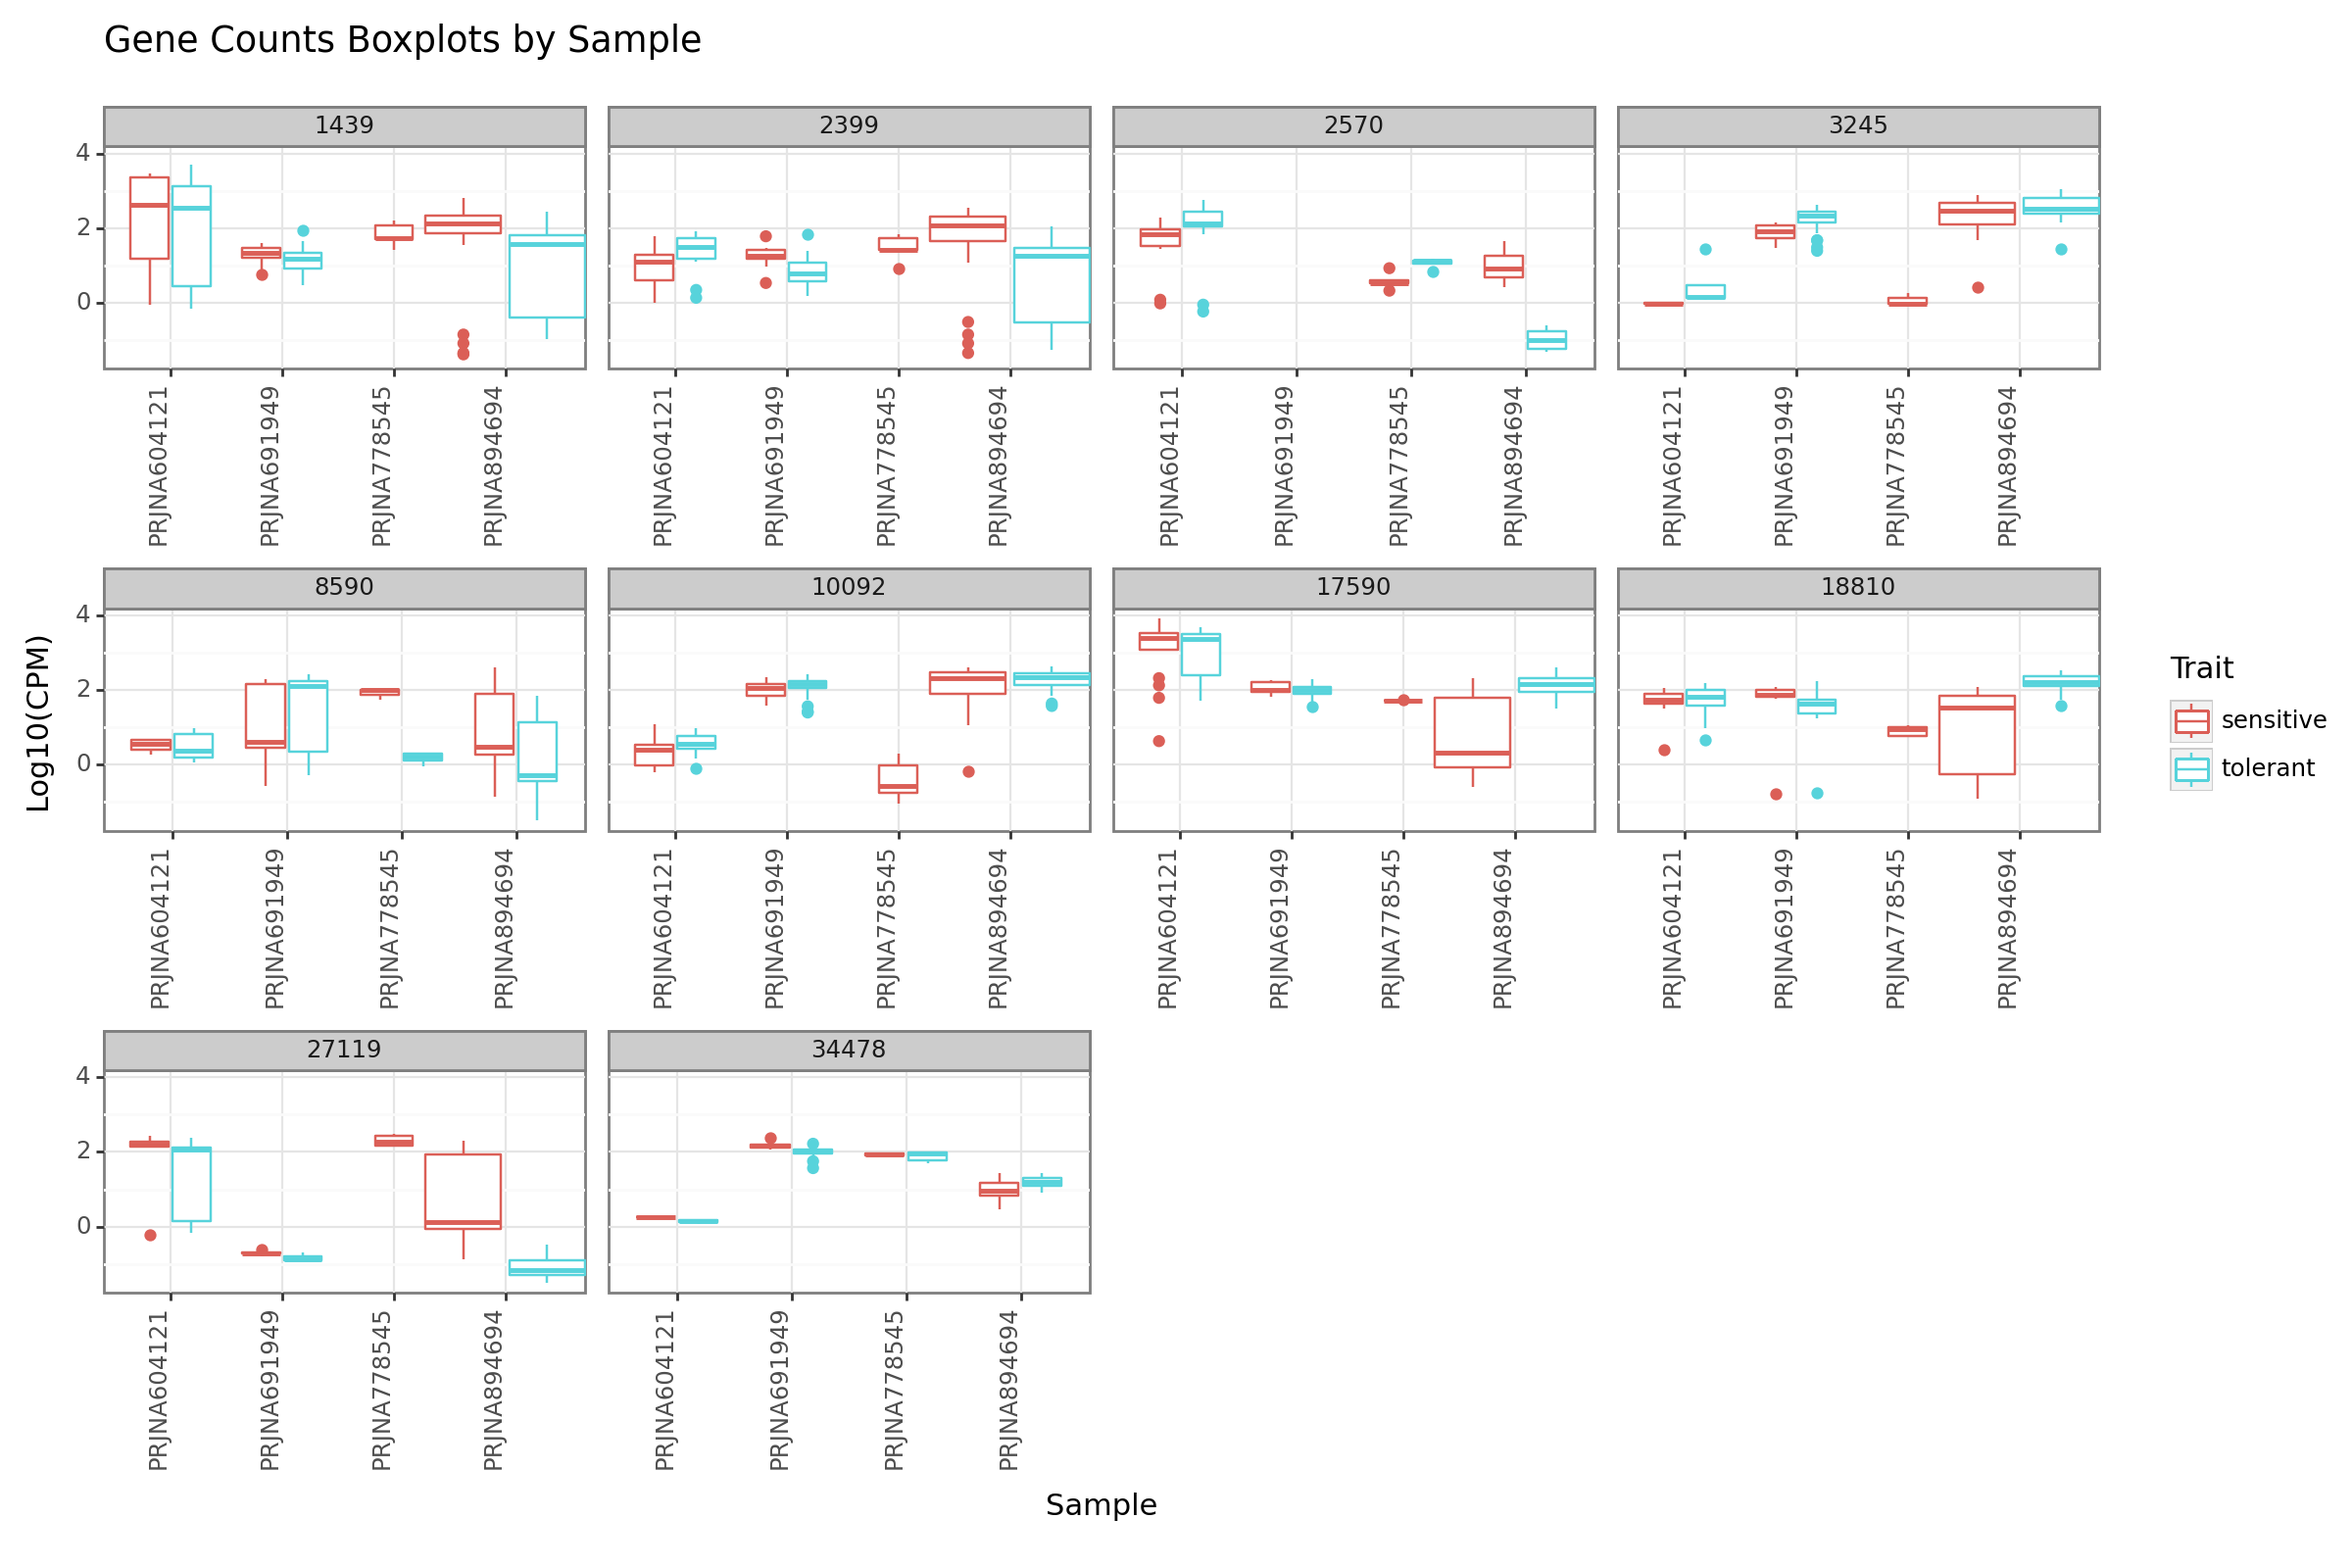

<Figure Size: (1200 x 800)>

In [134]:
#import library for plotting facet plots
from plotnine import *
%matplotlib inline

# Create boxplots for each sample
plt = (
    ggplot(sub_cpm_data, aes(x="BioProject", y="log_CPM", color = "Trait")) +
    geom_boxplot() +
    facet_wrap("~Gene", scales="free_x") +
    labs(title="Gene Counts Boxplots by Sample", y="Log10(CPM)", x="Sample") +
    theme_bw() +    
    theme(axis_text_x=element_text(rotation=90, hjust=1)) +
    theme(figure_size=(12, 8)  # Adjust width and height in inches
    )
)

display(plt)

In [131]:
#save subsetted data to analysis folder
sub_cpm_data.to_csv("../analyses/2025-01-03_RNAseq_all_AI_diffexp/MI500trait_top10genes.csv", index=False)

In [136]:
#save subsetted data to analysis folder
cpm_counts.to_csv("../analyses/2025-01-03_RNAseq_all_AI_diffexp/cpm_counts.csv", index=False)

ValueError: The condensed distance matrix must contain only finite values.

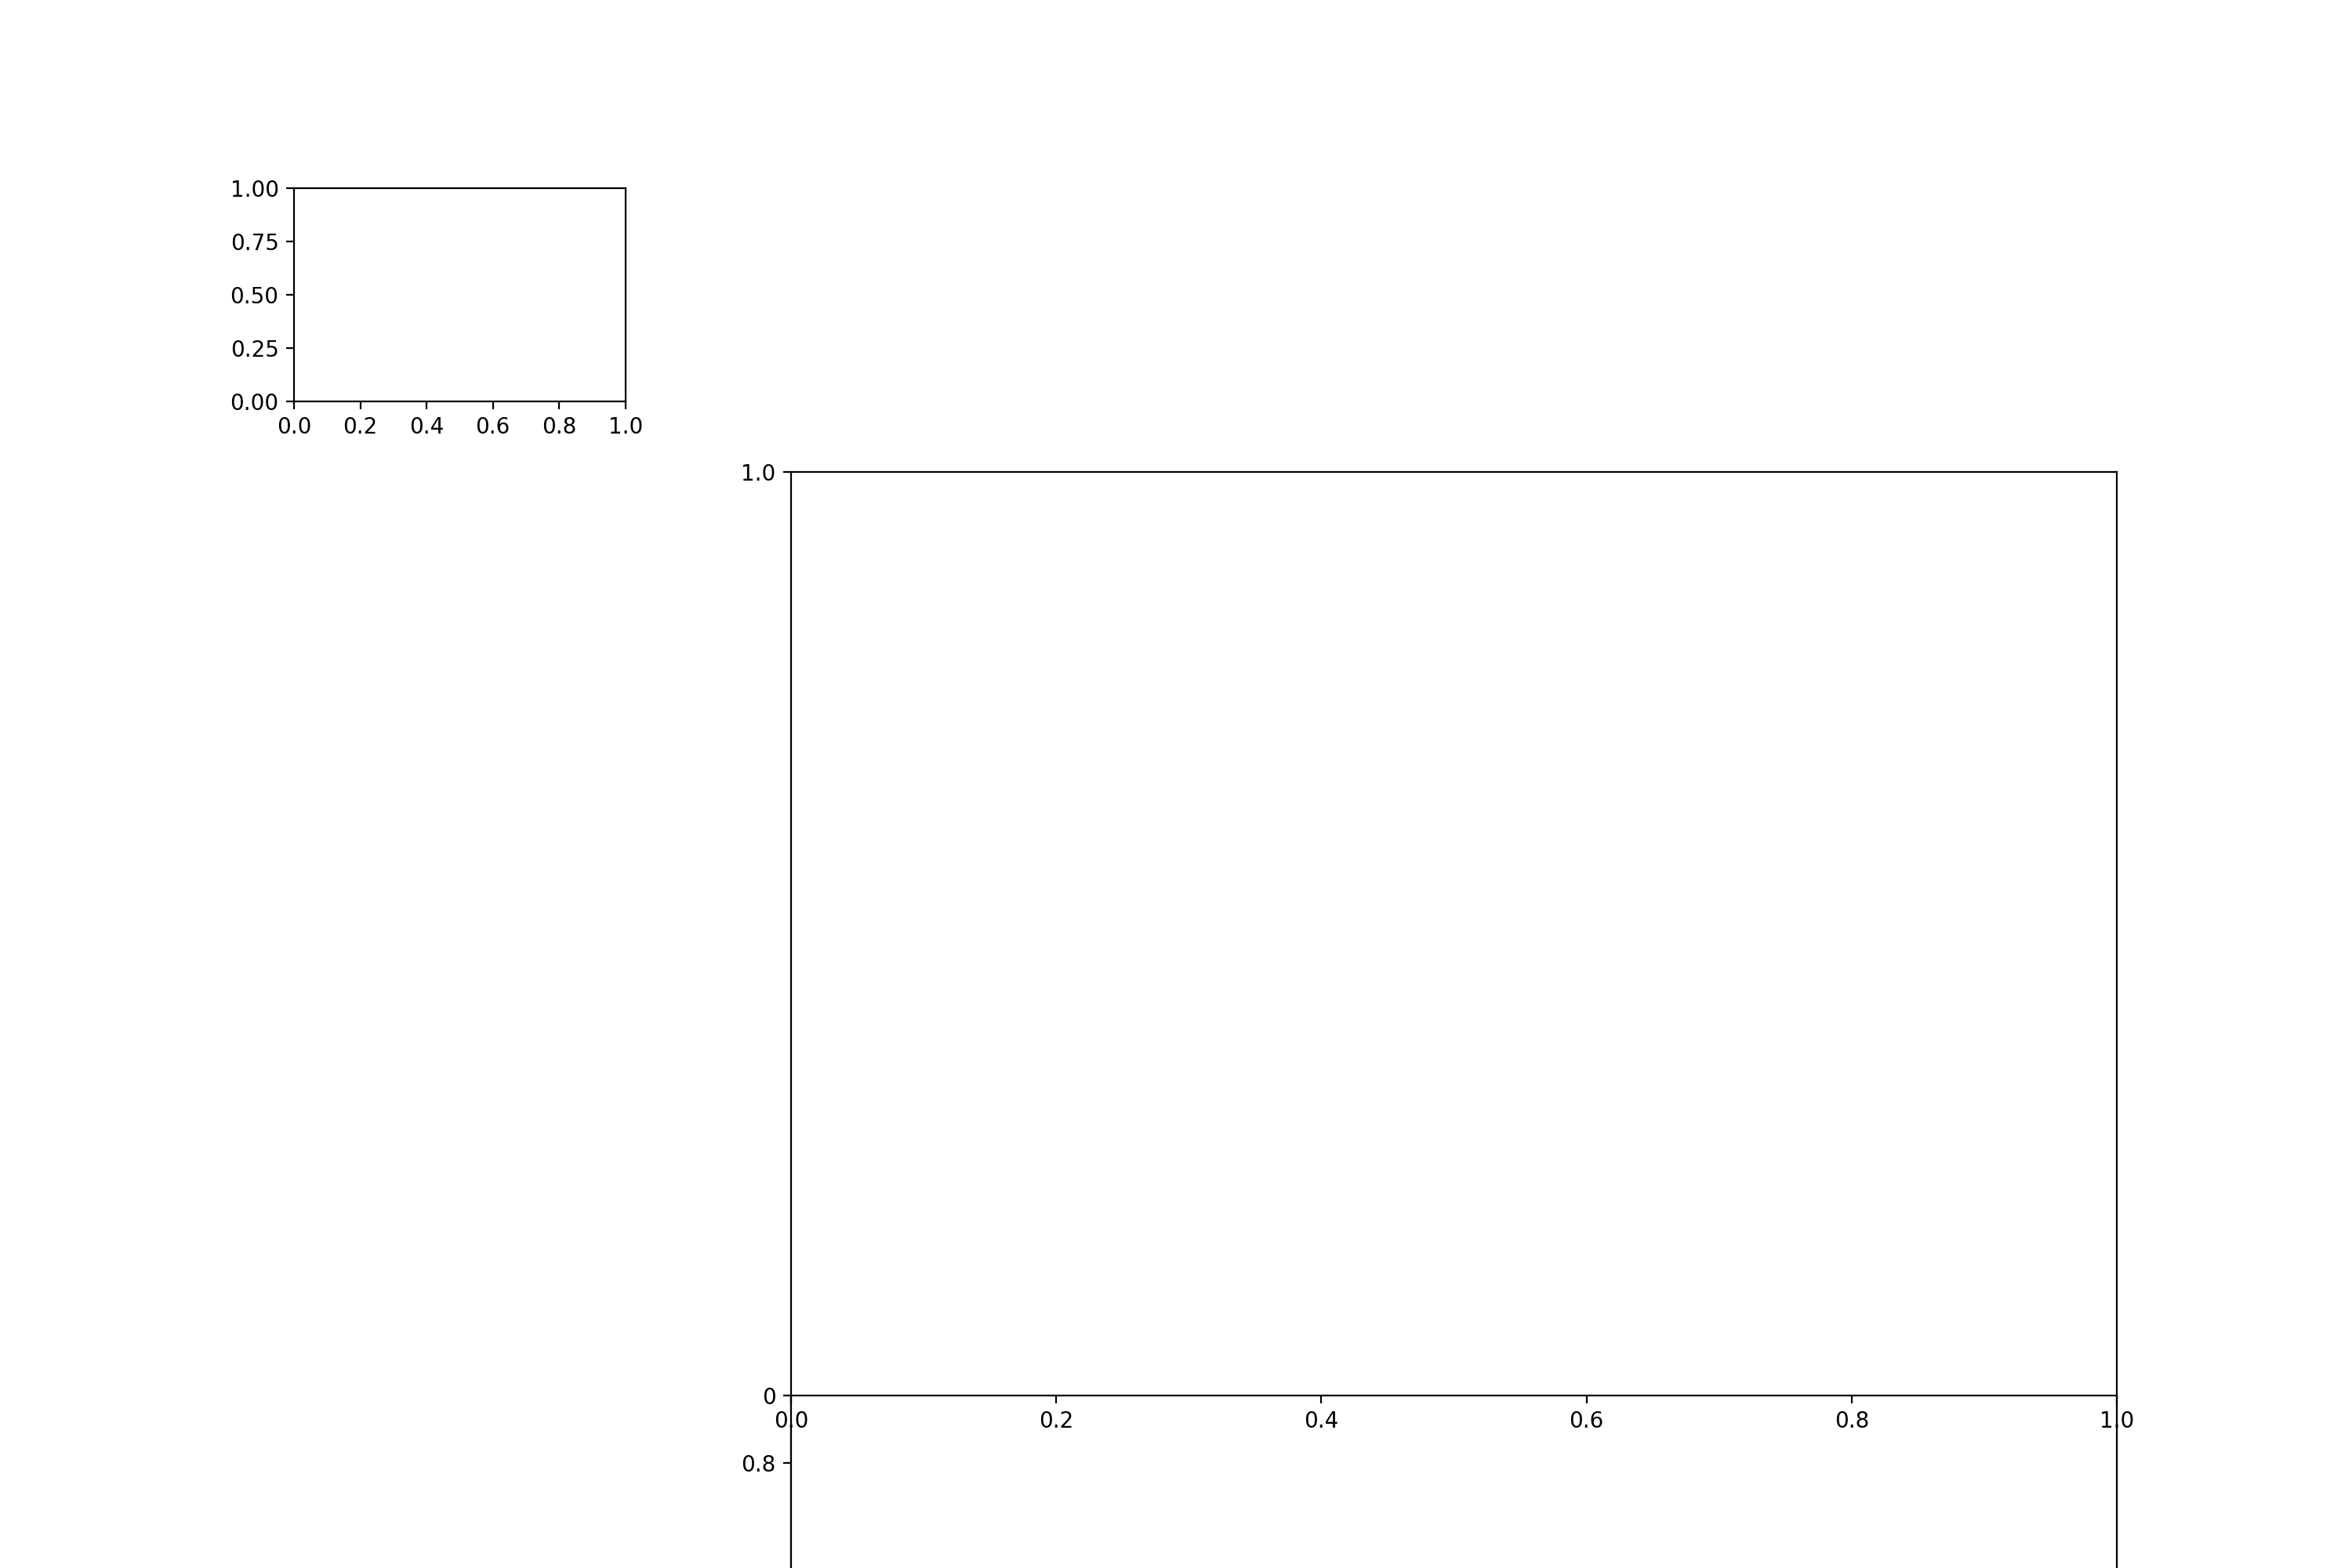

In [133]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from sklearn.preprocessing import LabelEncoder


# Pivot the data for the heatmap
heatmap_data = sub_cpm_data.pivot(index='Gene', columns='Sample', values='log_CPM')

# Extract metadata for color bars
sample_metadata = sub_cpm_data[['Sample', 'Trait', 'BioProject']].drop_duplicates().set_index('Sample')

# Generate color palettes
trait_palette = sns.color_palette("Set2", len(sample_metadata['Trait'].unique()))
bioproject_palette = sns.color_palette("Set3", len(sample_metadata['BioProject'].unique()))

# Map metadata to colors
trait_colors = dict(zip(sample_metadata['Trait'].unique(), trait_palette))
bioproject_colors = dict(zip(sample_metadata['BioProject'].unique(), bioproject_palette))

# Create color bars
col_colors = pd.DataFrame({
    'Trait': sample_metadata['Trait'].map(trait_colors),
    'BioProject': sample_metadata['BioProject'].map(bioproject_colors)
})

# Generate the clustered heatmap
g = sns.clustermap(
    heatmap_data,
    cmap="viridis",
    col_colors=col_colors.values,
    figsize=(15, 10),
    xticklabels=False,  # Hide sample labels for better readability
    yticklabels=True    # Keep gene labels
)

# Add legend for the color bars
for label, color_map in zip(['Trait', 'BioProject'], [trait_colors, bioproject_colors]):
    for key, color in color_map.items():
        g.ax_col_dendrogram.bar(0, 0, color=color, label=f"{label}: {key}", linewidth=0)

g.ax_col_dendrogram.legend(
    loc='center',
    ncol=2,
    bbox_to_anchor=(0.5, 1.1),
    bbox_transform=plt.gcf().transFigure,
    fontsize=10
)

# Show the plot
plt.show()


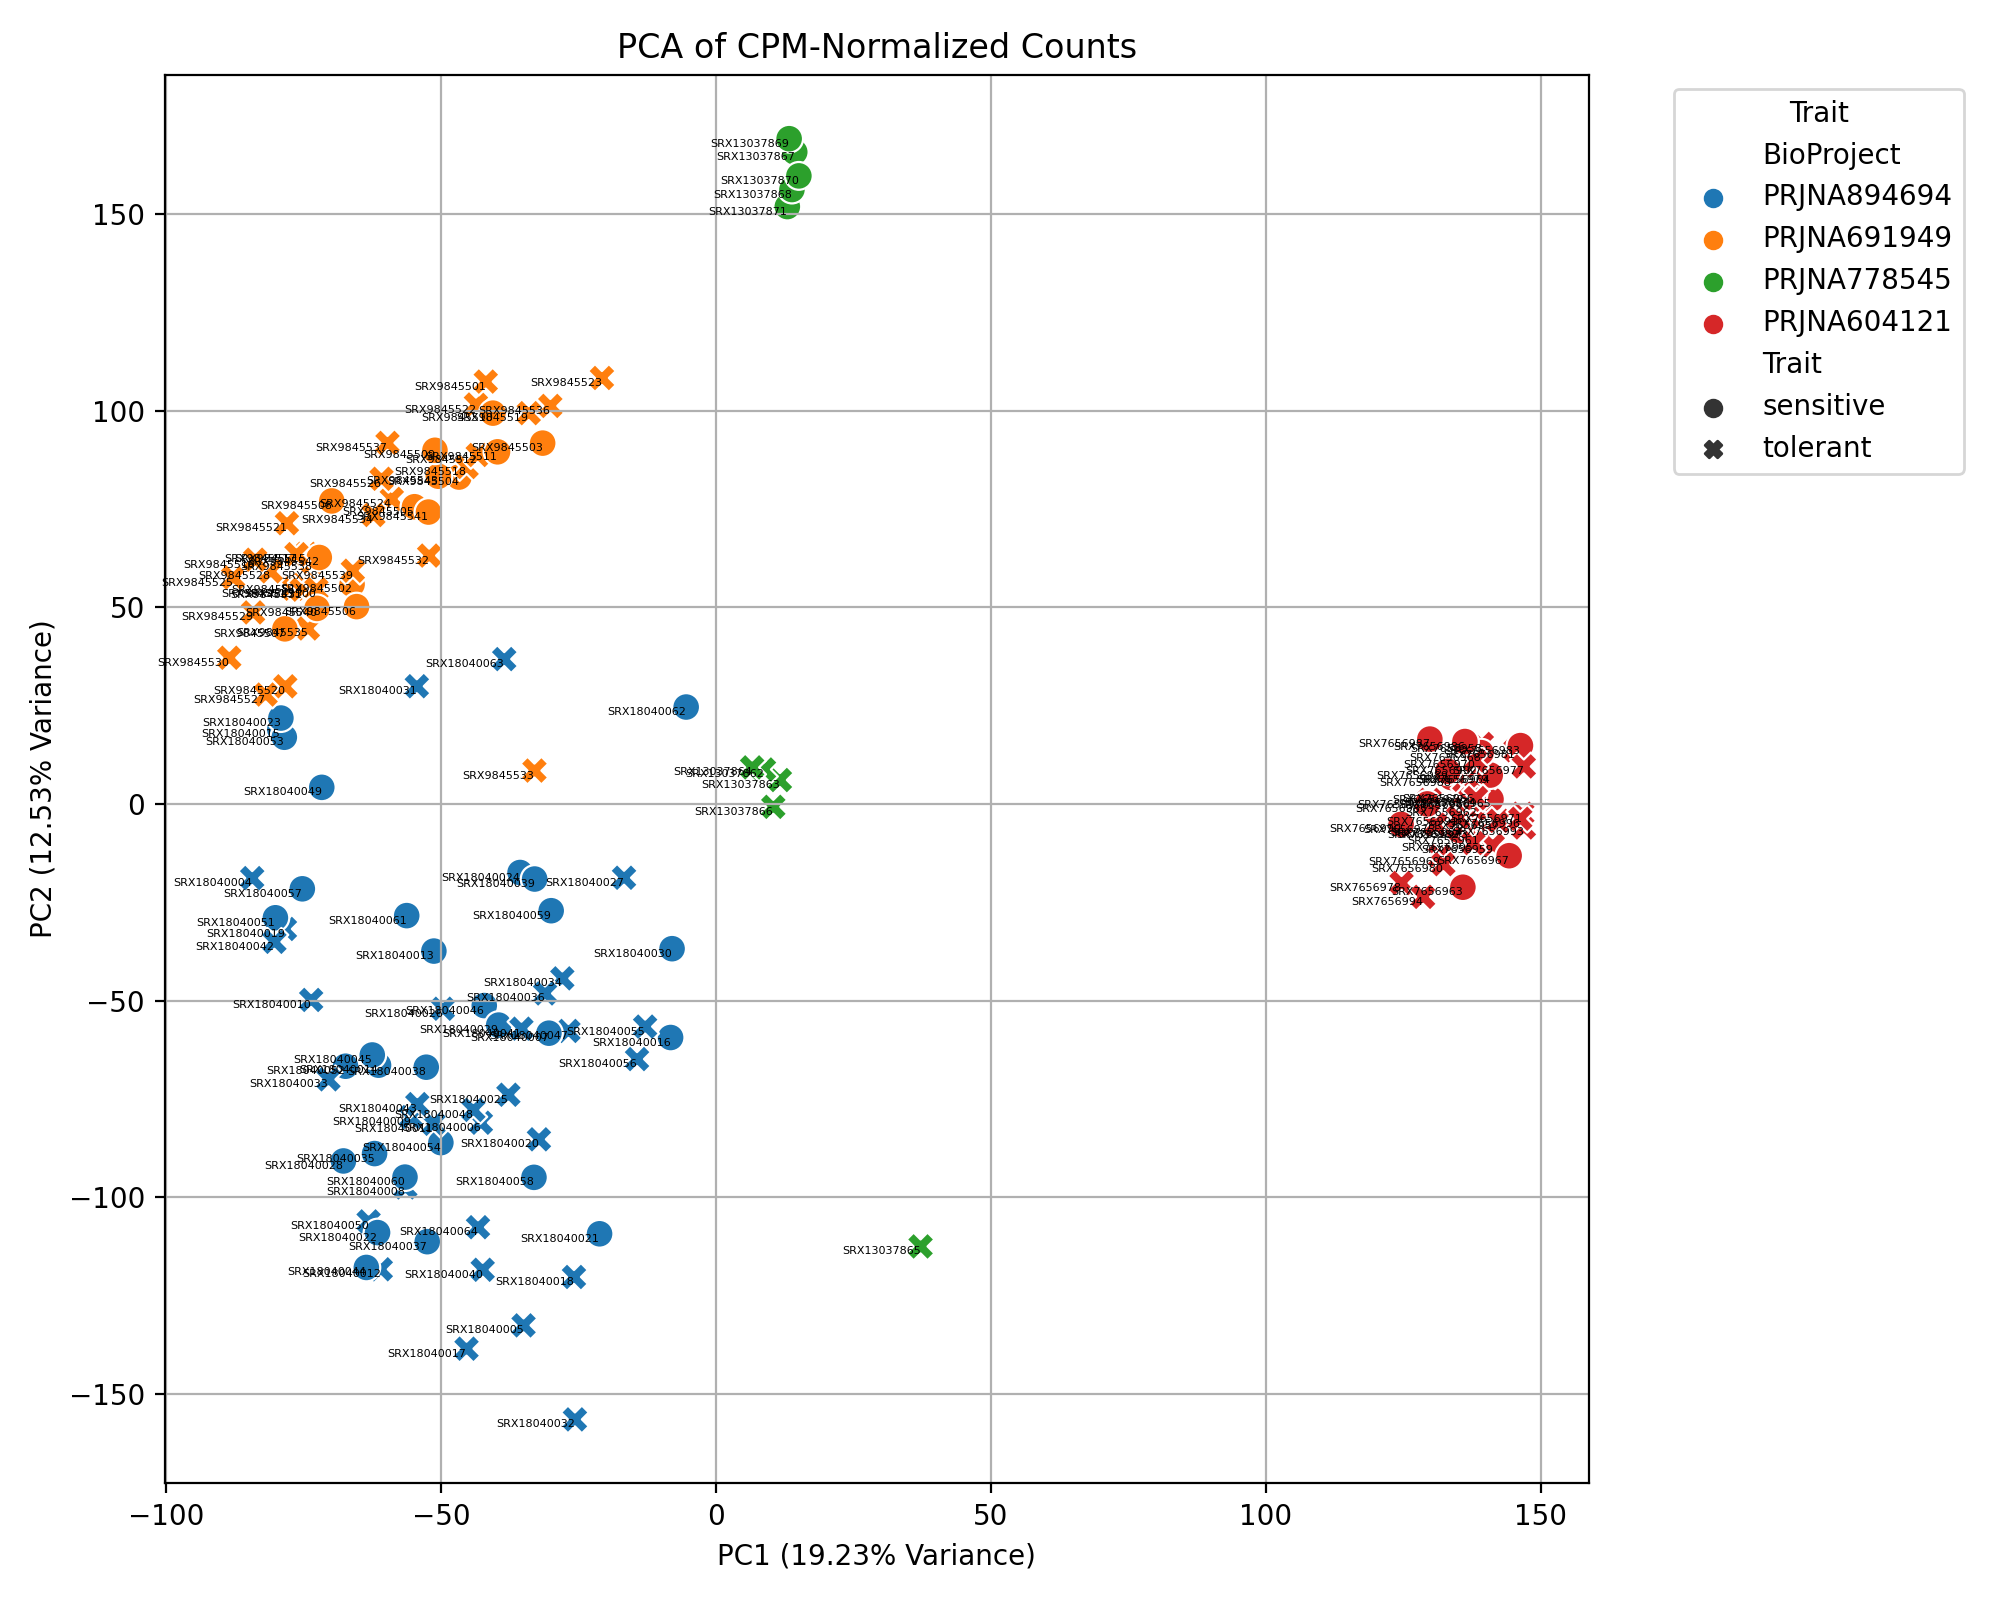

In [135]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Transpose the CPM data for PCA (genes as features, samples as rows)
pca_data_1 = cpm_values
pca_data_2 = cpm_values
pca_data_3 = cpm_values
pca_data_4 = cpm_values

cpm_values[cpm_values.rows.isin(pca_data.columns)]

# Standardize the data (mean=0, variance=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(np.log10(pca_data + 1))  # Log-transform CPM values

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 principal components
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Sample'] = pca_data.index

# Merge with metadata to color by treatment or batch
pca_df = pd.merge(pca_df, metadata, left_on='Sample', right_on='Sample')

# Plot PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=pca_df, 
    x='PC1', y='PC2', 
    hue='BioProject',  # Color by treatment
    style='Trait',    # Style points by batch
    s=100
)

# Add sample ID annotations
for i, row in pca_df.iterrows():
    plt.text(
        x=row['PC1'], 
        y=row['PC2'], 
        s=row['Sample'], 
        fontsize=4, 
        ha='right', 
        va='top'
    )
    
plt.title('PCA of CPM-Normalized Counts')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)')
plt.legend(title='Trait', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()